# 第一阶段 语义分割

#### 模型准备

In [ ]:
!pip list | grep torch
%cd /content/drive/MyDrive/ 
%ls
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html #colab会更新torch和cuda版本，对应mmcv版本也要及时更新

torch                         1.10.0+cu111
torchaudio                    0.10.0+cu111
torchsummary                  1.5.1
torchtext                     0.11.0
torchvision                   0.11.1+cu111
/content/drive/MyDrive
 cimg.rar            img.rar         label.rar
 cmask.rar           Iono2630_npy@   mmsegmentation/
'Colab Notebooks'/   Iono4311.rar    mmsegmentation17/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html


In [ ]:
%cd mmsegmentation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
import mmseg
print(mmseg.__version__)
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
import mmcv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os.path as osp
import numpy as np
from PIL import Image
import time

/content/drive/MyDrive/mmsegmentation
1.10.0+cu111 True
0.20.2


#### 定义数据集

In [ ]:
data_root = 'Iono4311'
img_dir = 'cimg'
ann_dir = 'cmask'
split_dir = 'splits'
label_dir = 'label'
classes = ('Background', 'E', 'Es-l', 'Es-c', 'F1', 'F2', 'Spread F')
palette = [[230, 230, 230], [250, 165, 30], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [130, 20, 12], [120, 121, 80]]
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
# 定义数据集类型，指定类名称，调色板，后缀等 打开你文件后第二次执行需要注释以下内容

@DATASETS.register_module()
class StandfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

KeyError: ignored

#### 加载模型


In [ ]:
from mmcv import Config
cfg = Config.fromfile('./work_dirs/ckpt/pspnet_ce.py')
model_path = './work_dirs/ckpt/' + 'iou_3922_acc_9153' + '.pth'
''' models
iou_3922_acc_9153
iou_5520_acc_7038
'''
# initialize segmentor
model = init_segmentor(cfg,  model_path, device='cuda:0') 

load checkpoint from local path: ./work_dirs/ckpt/iou_3922_acc_9153.pth


#### 使用模型推理

/content/drive/MyDrive/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


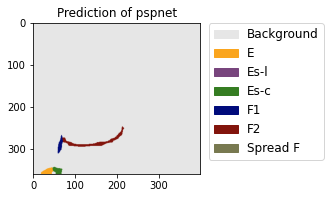

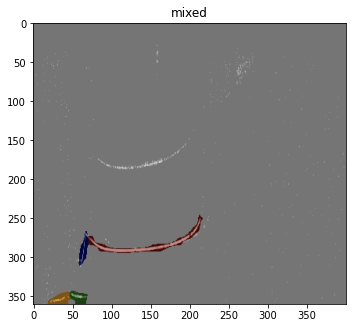

In [ ]:
# test a single image
img = mmcv.imread('Iono4311/cimg/20191106131500.png')
result = inference_segmentor(model, img)

# show result
plt.figure(figsize=(3,3))
plt.title('Prediction of pspnet')
seg_res = Image.fromarray(np.uint8(result[0])).convert('P')
seg_res.putpalette(np.array(palette, dtype=np.uint8))
im = plt.imshow(np.array(seg_res.convert('RGB')))
patches = [mpatches.Patch(color=np.array(palette[i])/255.,label=classes[i]) for i in range(7)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='large')

show_result_pyplot(model, img, result, fig_size=(5,5), title='mixed')

### 自定义函数


```
single_load
post_seg
interpret
show_cha_pyplot
```



#### 数据加载函数

```
[gimg, cimg, label, cmask, seg] = single_load(name)
```
单通道频高图gimg，三通道频高图cimg，分割图seg，真实标签label，伪彩图标签cmask


In [ ]:
import cv2
def single_load(name):
  label = cv2.imread(data_root + '/' + label_dir + '/' + name + '.png', cv2.IMREAD_GRAYSCALE) # 真实标签，gray ndarray
  cmask = Image.open(data_root + '/' + ann_dir + '/' + name + '.png')
  cimg = mmcv.imread(data_root + '/' + img_dir + '/' + name + '.png')  # numpy
  segs = inference_segmentor(model, cimg)
  gimg = cimg[:,:,0]  #单通道原图
  seg = segs[0]        # pspnet分割结果，gray ndarray
  return [gimg, cimg, label, cmask, seg]

#### 边缘检测函数


```
segmap = post_seg(seg, cimg)
```



In [ ]:
def post_seg(seg, cimg):
  th1 = 256*2
  th2 = 400
  blurred = cv2.GaussianBlur(cimg, (3, 3), 0)
  edge = cv2.Canny(blurred, 50, 150)
  edge = edge / 255
  # 与seg取交集
  segmap = seg * edge
  return segmap

#### e, f1, f2 层临界参数判读函数
```
[minh, maxf] = character(segmap)
[minh, maxf] = cha_e(segmap)
[minh, maxf] = cha_f1(segmap)
fmin = cha_fmin(segmap)
若某一层轨迹不存在则返回[-500,-1000]
```



In [ ]:
def character(segmap):
  minh = -1
  maxf = -1
  list_dh = []
  for i in range(359, -1, -1):
    for j in range(400):
      if (segmap[i,j] == 5) | (segmap[i,j] == 6):
        minh = i
        break
    if minh != -1:
      break

  for j in range(399,-1,-1):
    for i in range(minh, -1, -1):
      if (segmap[i,j] == 5) | (segmap[i,j] == 6):
        maxf = j
        break
    if maxf != -1:
      break
  return [minh, maxf]

def cha_e(segmap):
  minh = -1
  maxf = -1
  list_dh = []
  for i in range(359, -1, -1):
    for j in range(400):
      if (segmap[i,j] == 1):
        minh = i
        break
    if minh != -1:
      break

  for j in range(399,-1,-1):
    for i in range(minh, -1, -1):
      if (segmap[i,j] == 1):
        maxf = j
        break
    if maxf != -1:
      break
  if (minh == -1) | (maxf == -1):
    return[-500, -1000]
  return [minh, maxf]

def cha_f1(segmap):
  minh = -1
  maxf = -1
  list_dh = []
  for i in range(359, -1, -1):
    for j in range(400):
      if (segmap[i,j] == 4):
        minh = i
        break
    if minh != -1:
      break

  for j in range(399,-1,-1):
    for i in range(minh, -1, -1):
      if (segmap[i,j] == 4):
        maxf = j
        break
    if maxf != -1:
      break
  if (minh == -1) | (maxf == -1):
    return[-500, -1000]
  return [minh, maxf]

def cha_fmin(segmap):
  fmin = -1
  for j in range(400):
    for i in range(360):
      if (segmap[i,j] != 0):
        fmin = j
        break
    if fmin != -1:
      break
  return fmin
        

#### 参数判读函数


```
[mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin] = interpret(segmap)
```



In [ ]:
def interpret(segmap):
  # f2
  [mh_pred, mf_pred] = character(segmap)
  # e
  [mhe_pred, mfe_pred] = cha_e(segmap)
  # f1
  [mhf1_pred, mff1_pred] = cha_f1(segmap)
  # fmin
  fmin = cha_fmin(segmap)
  return [mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin]


#### 参数可视化函数


```
show_cha_pyplot(cimg, cmask, segmap, palette,
                            mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred,
                            mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth):

```



In [ ]:
def show_cha_pyplot(cimg, cmask, segmap, palette,
                                  mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin_pred,
                                  mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth):
  plt.figure(figsize=(28, 9))
  plt.subplot(131)
  plt.xlabel('Frequency (MHz)')
  plt.ylabel('Virtual Height (km)')
  plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
  plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
  # plt.title('Input Image')
  plt.imshow(cimg)

  plt.subplot(132)
  plt.xlabel('Frequency (MHz)')
  plt.ylabel('Virtual Height (km)')
  plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
  plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
  # plt.title('Ground Truth')
  plt.imshow(cmask)
  # f2
  plt.axvline(mf_truth,color='g',linestyle=":",alpha=0.8) 
  plt.text(mf_truth, -2,'foF2', color = 'g')
  plt.axhline(mh_truth,color='r',linestyle="--",alpha=0.8) 
  plt.text(401, mh_truth-3,'h\'F2', color = 'r')
  # E
  if mfe_truth > 0:
    plt.axvline(mfe_truth,color='g',linestyle=":",alpha=0.8) 
    plt.text(mfe_truth-6, -2,'foE', color = 'g')
    plt.axhline(mhe_truth,color='r',linestyle="--",alpha=0.8)
    plt.text(401, mhe_truth-3,'h\'E', color = 'r')
  # f1
  if mff1_truth > 0:
    plt.axvline(mff1_truth,color='g',linestyle=":",alpha=0.8) 
    plt.text(mff1_truth, -2,'foF1', color = 'g')
    plt.axhline(mhf1_truth,color='r',linestyle="--",alpha=0.8)  
    plt.text(401, mhf1_truth-3,'h\'F1', color = 'r')
  if fmin_pred > 0:
    plt.axvline(fmin_truth,color='g',linestyle=":",alpha=0.8) 
    plt.text(fmin_truth-18, -2,'fmin', color = 'g')

  plt.subplot(133)
  plt.xlabel('Frequency (MHz)')
  plt.ylabel('Virtual Height (km)')
  plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
  plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
  # plt.title('Final Prediction')
  seg_res = Image.fromarray(np.uint8(segmap)).convert('P')
  seg_res.putpalette(np.array(palette, dtype=np.uint8))
  im = plt.imshow(np.array(seg_res.convert('RGB')))
  plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='large')
  # f2
  plt.axvline(mf_pred,color='g',linestyle=":",alpha=0.8) 
  plt.text(mf_pred, -2,'foF2', color = 'g')
  plt.axhline(mh_pred,color='r',linestyle="--",alpha=0.8) 
  plt.text(401, mh_pred-3,'h\'F2', color = 'r')
  # E
  if mfe_pred > 0:
    plt.axvline(mfe_pred,color='g',linestyle=":",alpha=0.8) 
    plt.text(mfe_pred-6, -2,'foE', color = 'g')
    plt.axhline(mhe_pred,color='r',linestyle="--",alpha=0.8) 
    plt.text(401, mhe_pred-3,'h\'E', color = 'r')
  # f1
  if mff1_pred > 0:
    plt.axvline(mff1_pred,color='g',linestyle=":",alpha=0.8) 
    plt.text(mff1_pred, -2,'foF1', color = 'g')
    plt.axhline(mhf1_pred,color='r',linestyle="--",alpha=0.8) 
    plt.text(401, mhf1_pred-3,'h\'F1', color = 'r')
  if fmin_pred > 0:
    plt.axvline(fmin_pred,color='g',linestyle=":",alpha=0.8) 
    plt.text(fmin_pred-18, -2,'fmin', color = 'g')
  # save as png
  plt.savefig('results/'+str(cnt)+'.png')
  plt.show()

#### 完整的单张图片推理并画图

['20191108083000', '20191108080000', '20191108084500', '20191108090000', '20191108073000', '20191108074500', '20191108091500', '20191108104500', '20191108103000', '20191108101500', '20191108111500', '20191108093000', '20191108094500', '20191108100000', '20191108110000', '20191108131500', '20191108120000', '20191108113000', '20191108130000', '20191108114500', '20191108124500', '20191108123000', '20191108121500', '20191108144500', '20191108150000', '20191108140000', '20191108141500', '20191108143000', '20191108153000', '20191108151500', '20191108134500', '20191108163000', '20191108154500', '20191108160000', '20191108173000', '20191108161500', '20191108170000', '20191108171500', '20191108164500', '20191108180000', '20191108190000', '20191108183000', '20191108174500', '20191108191500', '20191108181500', '20191108193000', '20191108184500', '20191108214500', '20191108203000', '20191108211500', '20191108213000', '20191108201500', '20191108200000', '20191108220000', '20191108221500', '20191108

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


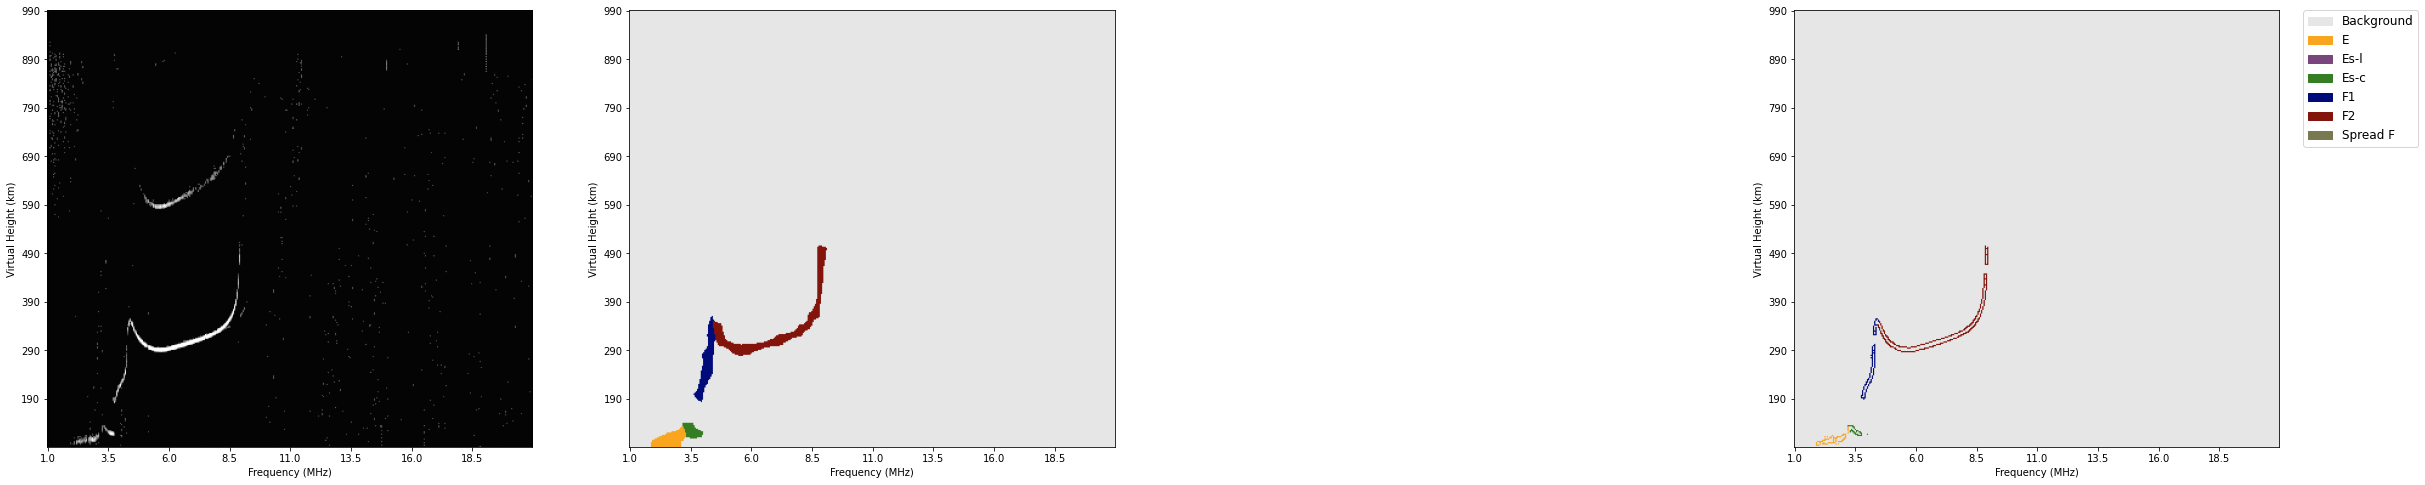

In [ ]:
import sys
name_list=[]
with open("/content/drive/MyDrive/mmsegmentation/Iono4311/splits/val.txt", "r") as f:  # 打开文件
	for line in f:
		name_list.append(''.join(line.strip('\n').split(',')))
print(name_list)
name = name_list[780]
[gimg, cimg, label, cmask, seg] = single_load(name)
# plt.figure(figsize=(20, 16))
# plt.subplot(121)
# plt.title('Input Ionogram')
# plt.imshow(cimg)
# plt.subplot(122)
# plt.title('Ground Truth')
# plt.imshow(cmask)
# seg_res = Image.fromarray(np.uint8(segmap)).convert('P')
# seg_res.putpalette(np.array(palette, dtype=np.uint8))
# im = plt.imshow(np.array(seg_res.convert('RGB')))
# plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='large')
# plt.show()
# print(name)


blurred = cv2.GaussianBlur(cimg, (3, 3), 0)
edge = cv2.Canny(blurred, 50, 150)
edge = 1 - edge / 255
# 与seg取交集
segmap = seg * edge
segmap = post_seg(seg, cimg)

plt.figure(figsize=(40, 9))
plt.subplot(141)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Virtual Height (km)')
plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
# plt.title('Input Ionogram')
plt.imshow(cimg)
plt.subplot(142)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Virtual Height (km)')
plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
# plt.title('Edges of the trace')
plt.imshow(cmask)
# plt.imshow(edge, cmap='binary')
plt.subplot(142)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Virtual Height (km)')
plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
# plt.title('Prediction of segmentation networks')
seg_res = Image.fromarray(np.uint8(seg)).convert('P')
seg_res.putpalette(np.array(palette, dtype=np.uint8))
im = plt.imshow(np.array(seg_res.convert('RGB')))
patches = [mpatches.Patch(color=np.array(palette[i])/255.,label=classes[i]) for i in range(7)]
plt.subplot(144)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Virtual Height (km)')
plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
# plt.title('Edge of each layer')
seg_res = Image.fromarray(np.uint8(segmap)).convert('P')
seg_res.putpalette(np.array(palette, dtype=np.uint8))
im = plt.imshow(np.array(seg_res.convert('RGB')))
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='large')
plt.savefig('results/mask.png')
plt.show()


# 第二阶段 分割图后处理、参数判读

#### 导入验证集图片

In [ ]:
import sys
name_list=[]
with open("/content/drive/MyDrive/mmsegmentation/Iono4311/splits/val.txt", "r") as f:  # 打开文件
	for line in f:
		name_list.append(''.join(line.strip('\n').split(',')))
N = len(name_list)
print(N)

863


### 遍历验证集，计算参数并可视化

No. 551
15 16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: The handle <matplotlib.patches.Rectangle object at 0x7f130c9c2cd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: The handle <matplotlib.patches.Rectangle object at 0x7f130c9c2110> has a label of '_nolegend_' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: The handle <matplotlib.patches.Rectangle object at 0x7f130c9c2e10> has a label of '_nolegend_' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: The handle <matplotlib.patches.Rectangle object at 0x7f130c9c2650> has a label of '_nolegend_' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: The handle <matplotlib.pat

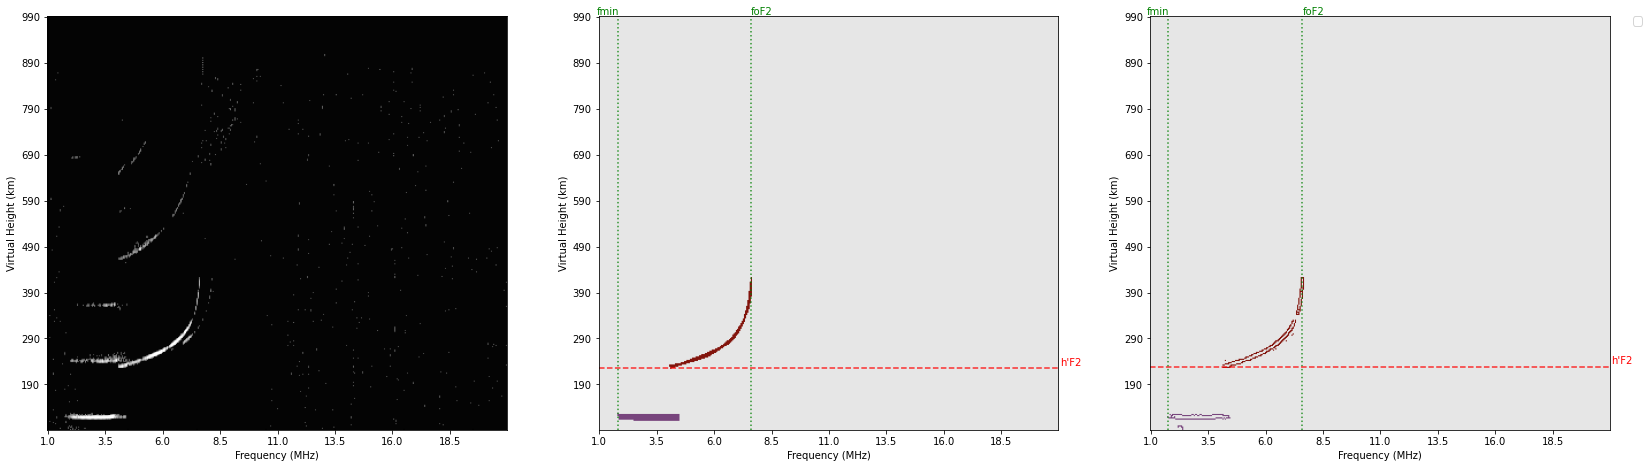

No. 552
17 19


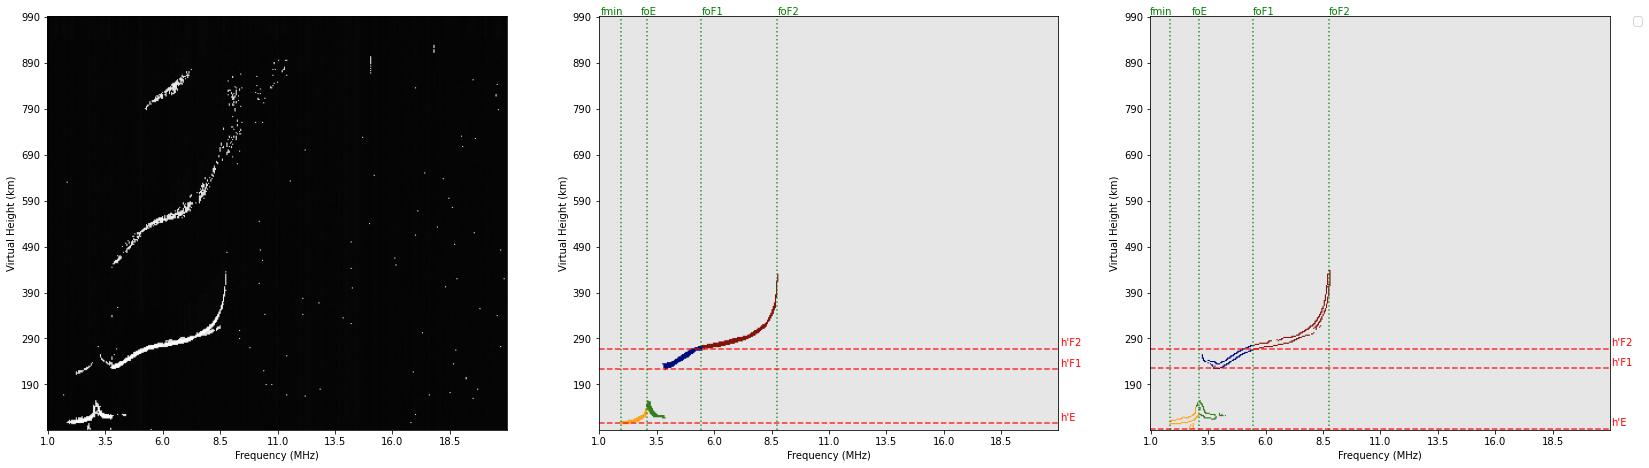

No. 553
15 15


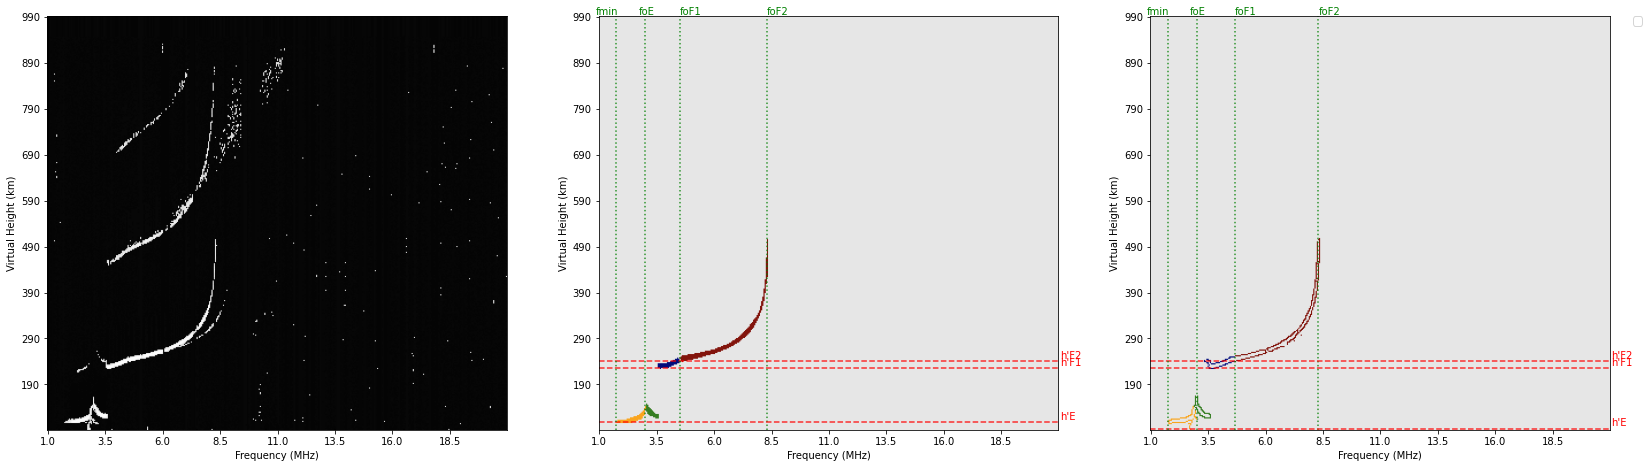

No. 554
17 18


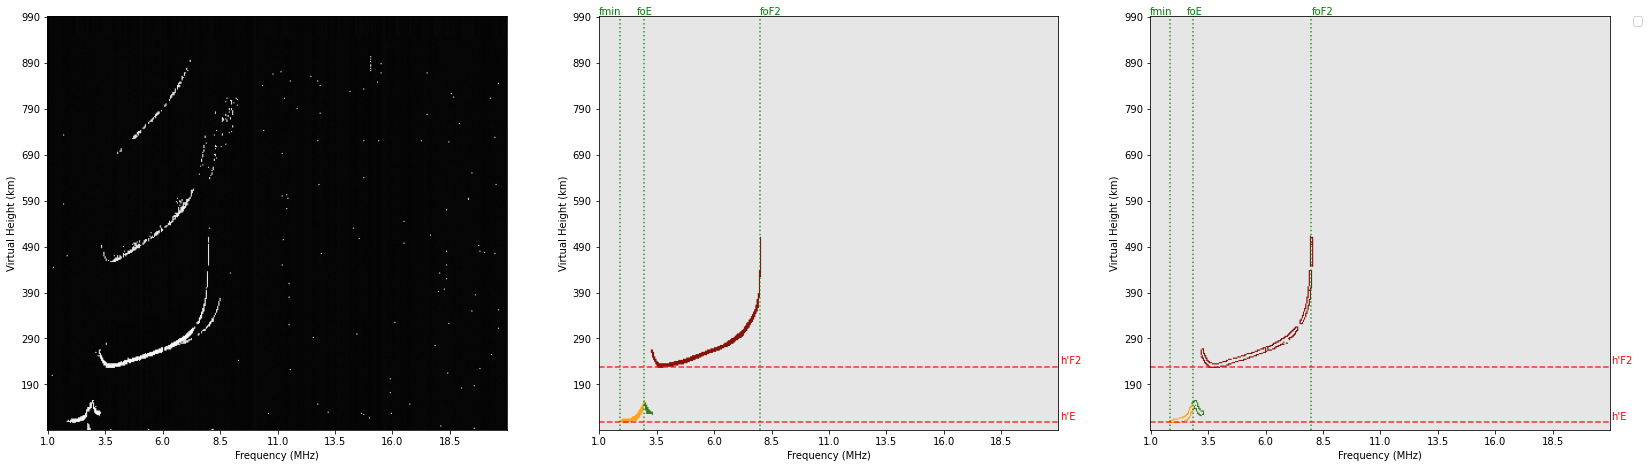

No. 555
21 23


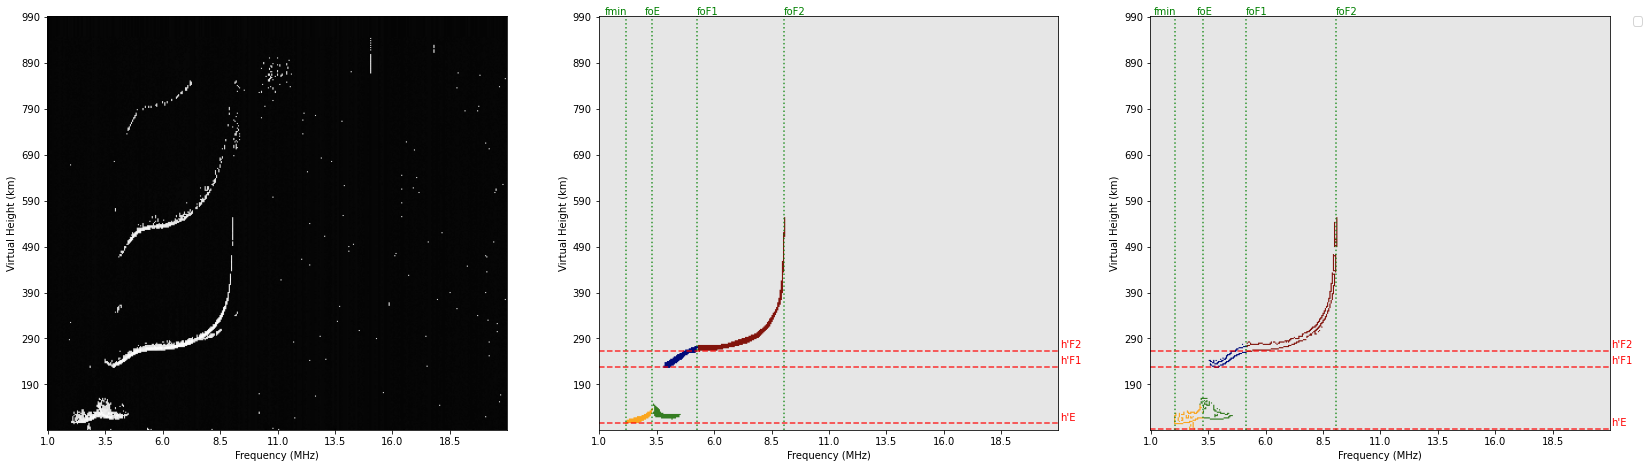

No. 556
15 19


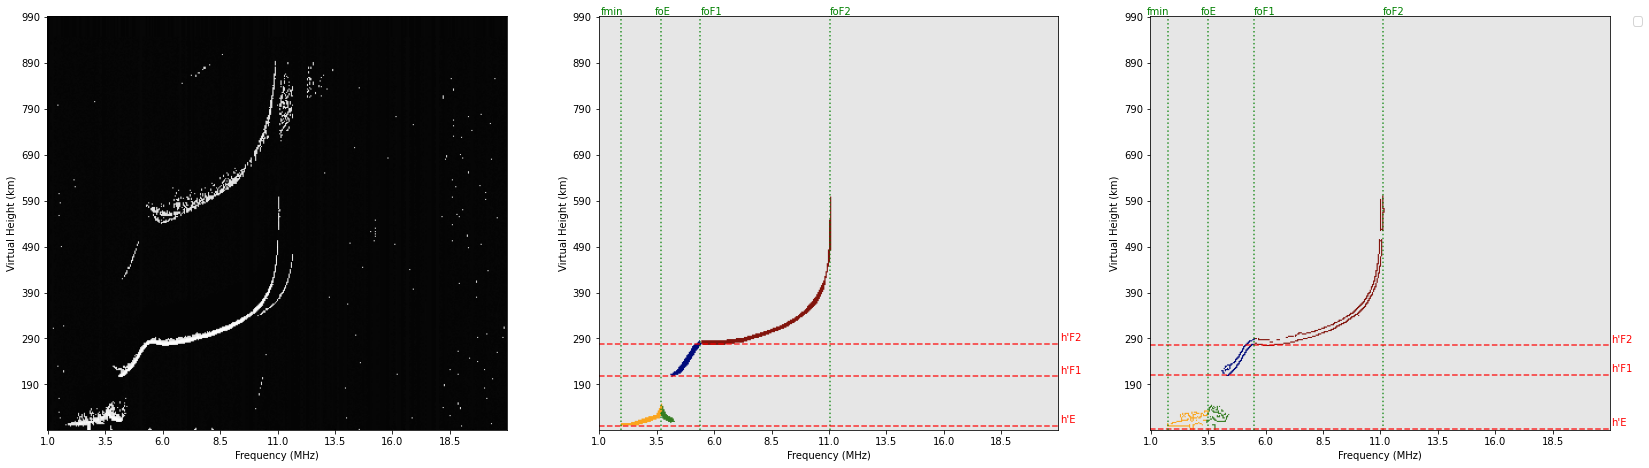

No. 557
15 20


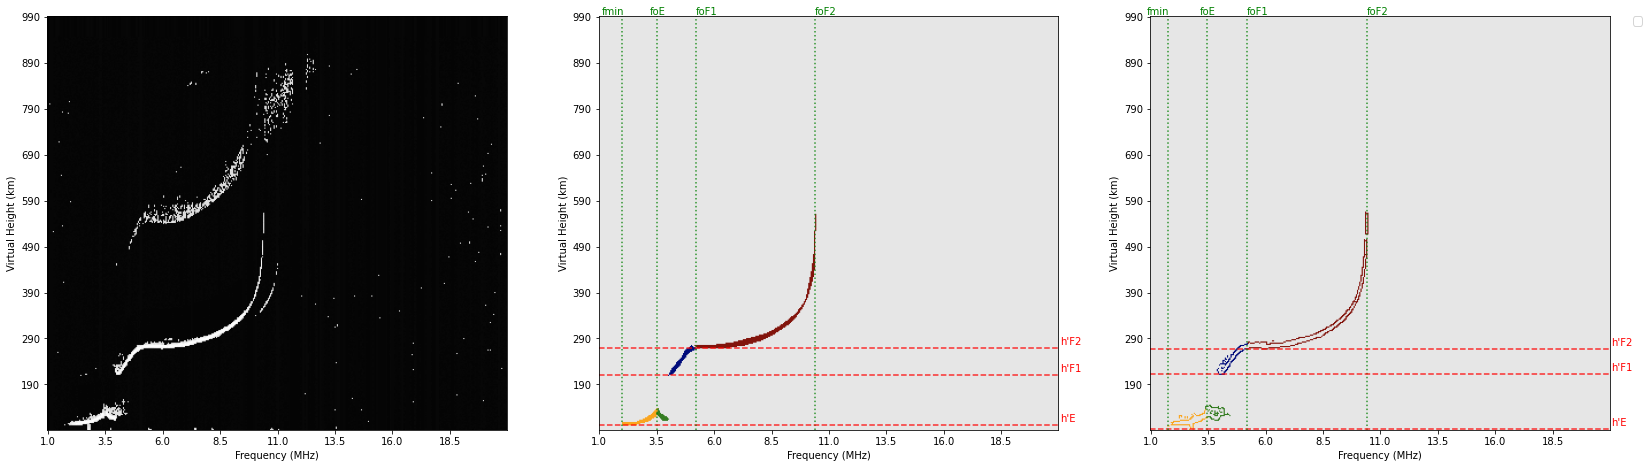

No. 558
16 22


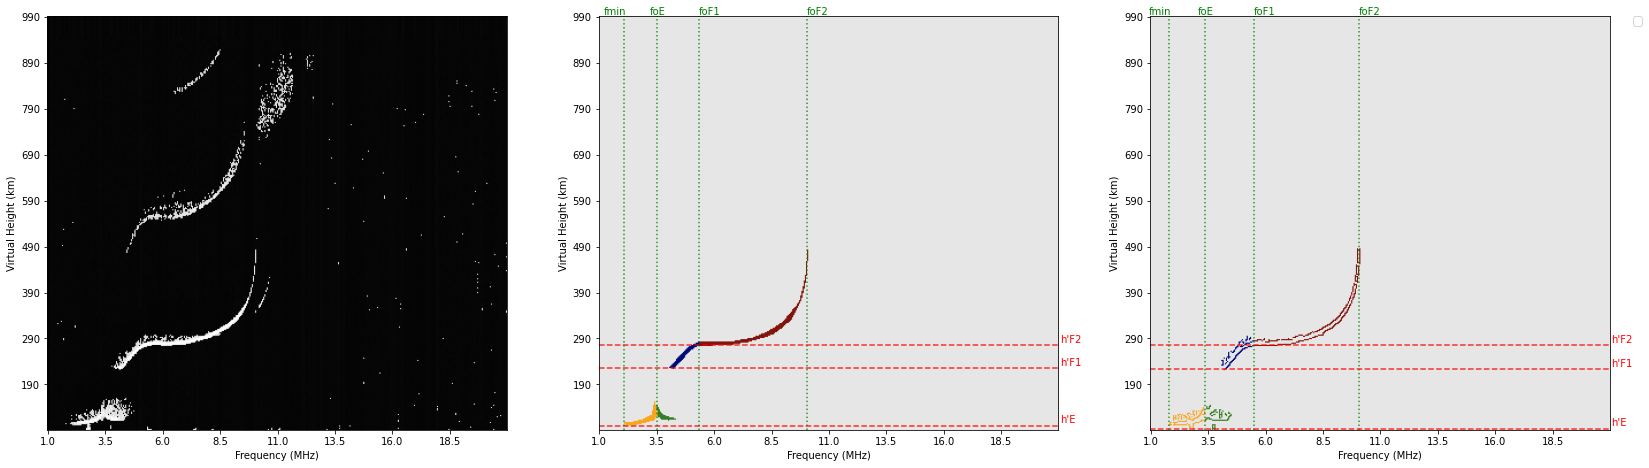

No. 559
14 19


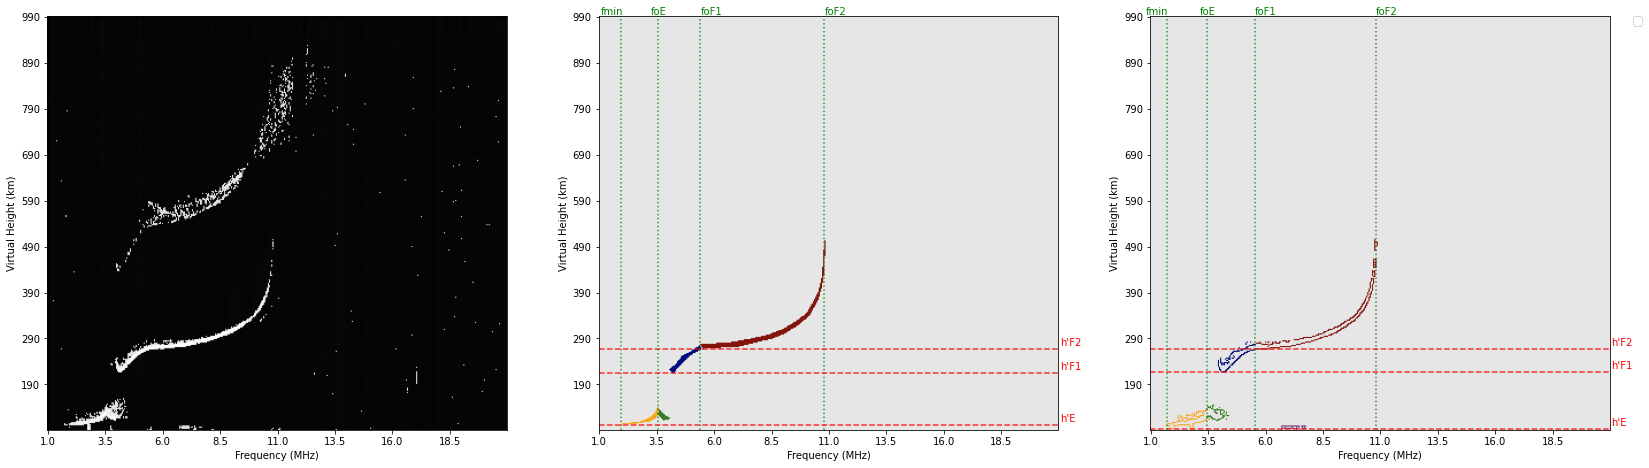

No. 560
17 22


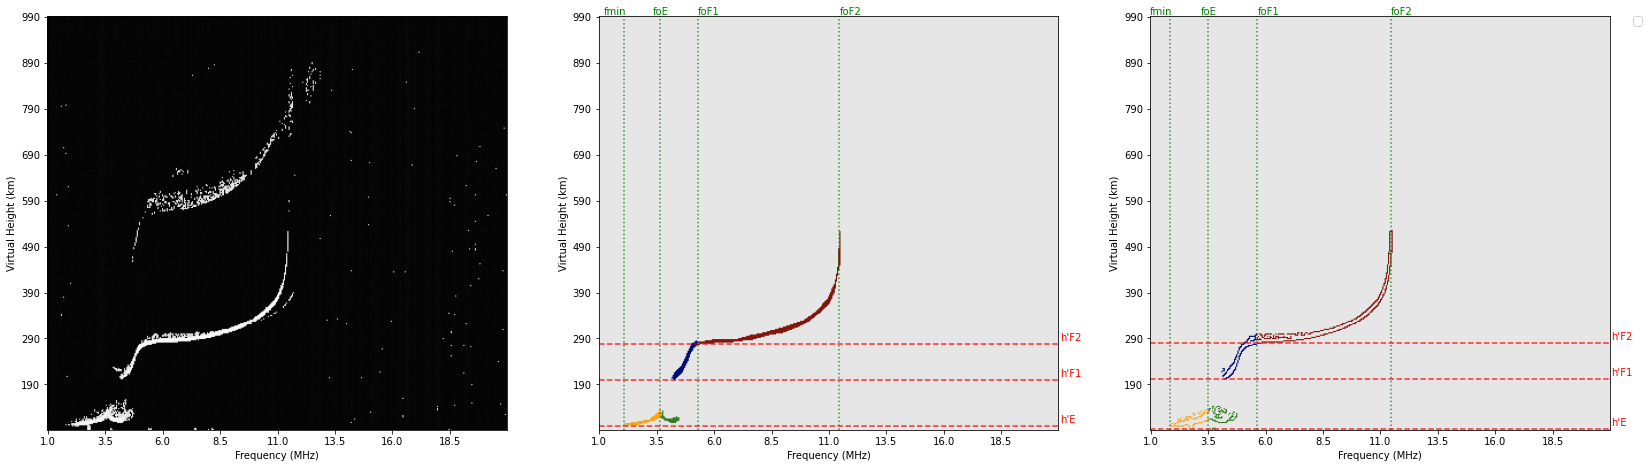

No. 561
16 23


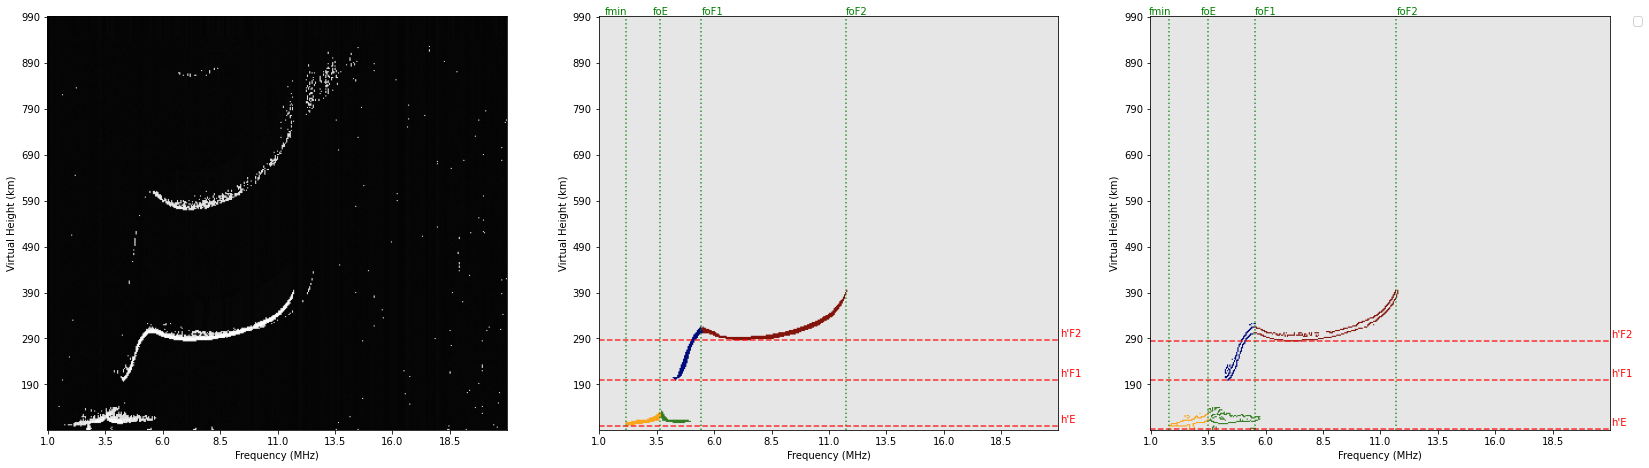

No. 562
20 22


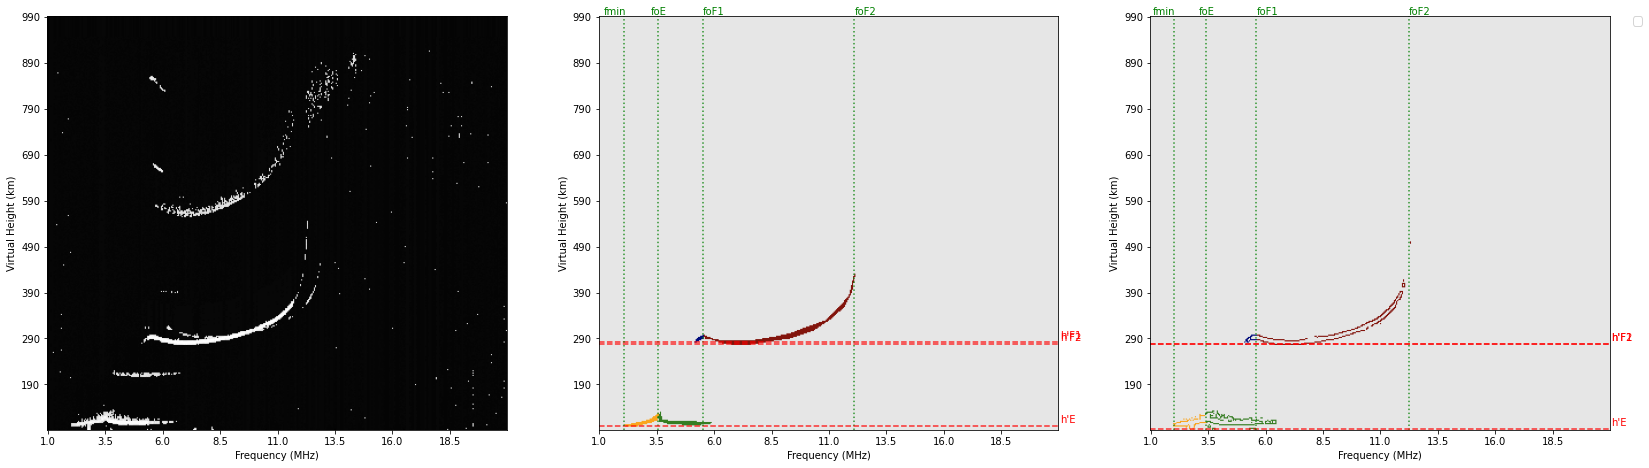

No. 563
20 21


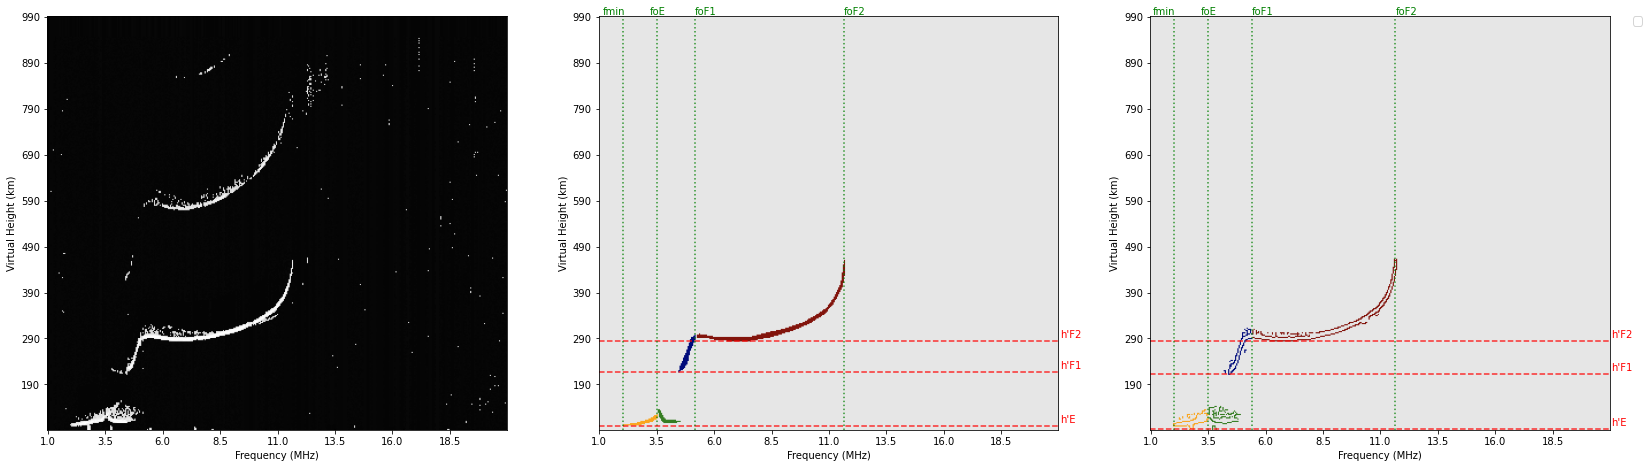

No. 564
21 24


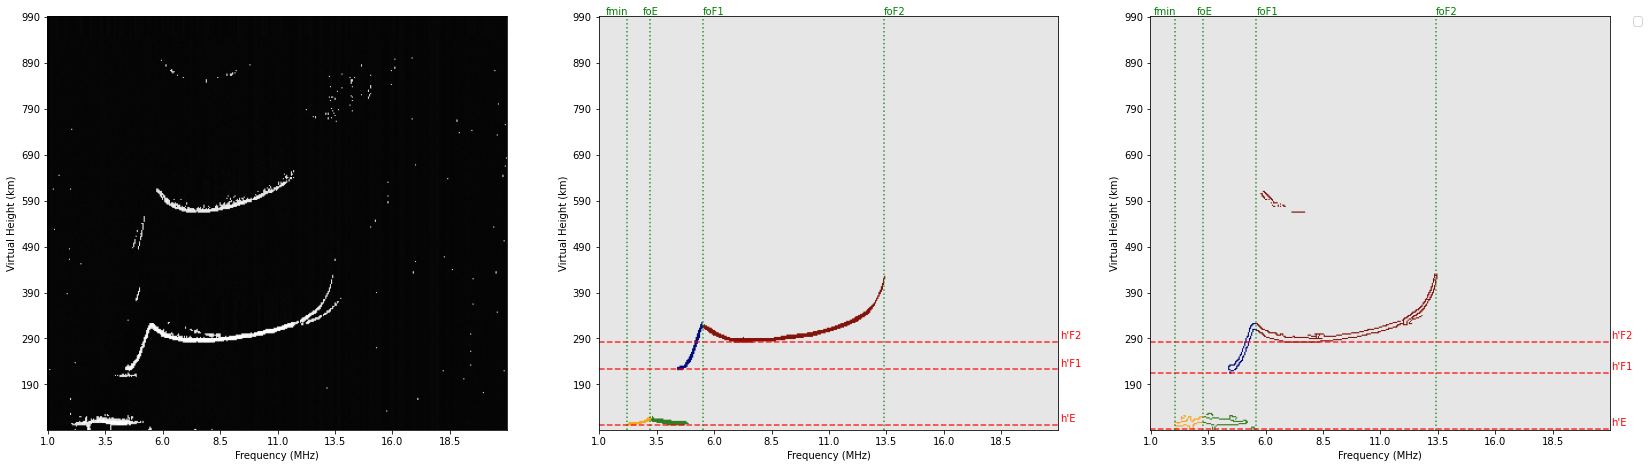

No. 565


In [ ]:
# 202开始有Fspread
cnt = 551                          # 开始序号
sample_interval = 1   # 画图抽样间隔
tic1  = time.perf_counter()

while cnt < N:
  print('No.', cnt)
  name = name_list[cnt]
  [gimg, cimg, label, cmask, seg] = single_load(name)
  segmap = seg
  ############ postprocess###########
  segmap = post_seg(seg, cimg)        
  
  # 计算临界参数
  [mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin_pred] = interpret(segmap)
  [mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth] = interpret(label)
  mf_pred = mf_pred - 1
  print(fmin_pred,fmin_truth)
  show_cha_pyplot(cimg, cmask, segmap, palette,
                            mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin_pred,
                            mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth)
  
  cnt = cnt + sample_interval
tic2  = time.perf_counter()
print(tic2 - tic1,'s')

### 遍历验证集，分析最终结果

#### 计算并保存参数

In [ ]:
cfg = Config.fromfile('./work_dirs/ckpt/pspnet_ce.py')
model_path = './work_dirs/ckpt/' + 'iou_3589_acc_9352' + '.pth'
model = init_segmentor(cfg,  model_path, device='cuda:0') 
'''
iou_4180_acc_8891
iou_3922_acc_9153
'''
cnt = 0
sample_interval = 1
tic1  = time.perf_counter()

# 保存pred和truth参数到列表
list_pred = []
list_truth = []

# for name in name_list:
while cnt < N:

  # print('\nNo.', cnt)
  name = name_list[cnt]
  # 两阶段推理
  [gimg, cimg, label, cmask, seg] = single_load(name)
  # segmap = seg
  ############ postprocess###########
  segmap = post_seg(seg, cimg) 

   # 计算所有临界参数
  [mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin_pred] = interpret(segmap)
  [mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth] = interpret(label)
  mf_pred = mf_pred - 1

  # 计算混淆矩阵
  # cm = cm + confusion_matrix(label.flatten(), segmap.flatten(), labels=range(7))

  # 保存参数到list
  list_pred.append([mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin_pred])
  list_truth.append([mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth])
  

  if cnt % 20 == 0:
    tic2  = time.perf_counter()
    print(cnt, '/', N, 'time:', tic2-tic1, 's')

  cnt = cnt + sample_interval

cha_pred = np.array(list_pred)
cha_truth = np.array(list_truth)
np.save('./work_dirs/npz/pred_3589', cha_pred)
np.save('./work_dirs/npz/target_3589', cha_truth)

#### 绘制参数偏差直方图

(1589, 4)
fmin cases 858
dh cases 1589 dfcases 2447
[-135.   -50.   -47.5  -45.   -42.5  -40.   -32.5  -30.   -27.5  -25.
  -22.5  -20.   -17.5  -15.   -12.5  -10.    -7.5   -5.    -2.5    0.
    2.5    5.     7.5   10.    12.5   15.    17.5   20.    30.    37.5
   40.    57.5]
[-2.05 -1.7  -1.6  -1.45 -1.4  -1.3  -1.25 -1.2  -1.15 -1.1  -1.   -0.95
 -0.9  -0.85 -0.8  -0.75 -0.7  -0.65 -0.6  -0.55 -0.5  -0.45 -0.4  -0.35
 -0.3  -0.25 -0.25 -0.2  -0.15 -0.1  -0.1  -0.05  0.    0.05  0.1   0.15
  0.2   0.25  0.3   0.3   0.35  0.4   0.45  0.7   0.8   1.1   1.55  1.65
  1.8   1.95  4.    5.15]
('dhF2 <= 10km:', 0.9883449883449883)
('dfoF2 <= 0.2MHz:', 0.972027972027972)
mean absolute DH 2.882315921963499
mean absolute DF 0.0911728647323253

mean DH -0.9848961611076148
mean DF -0.02288516550878627
mean DFmin -0.09026806526806527


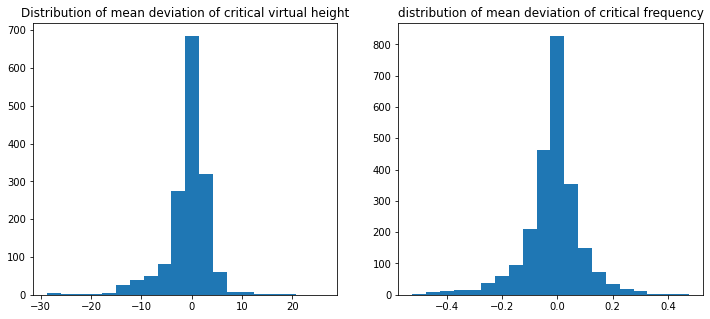

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
cha_pred = np.load('./work_dirs/npz/pred_3589.npy')
cha_truth = np.load('./work_dirs/npz/target_3589.npy')
# mh_f2,  mf_f2,  mh_e,  mf_e,  mh_f1, mf_f1
list_dF2 = []

dh = 0
df = 0
list_d = []   #[i, j, dh, df]    @i: 验证集图片序号 @j: {0: f2; 2: e; 4: f1; 6:fmin}
list_dfmin = []
cnt = 0
for i in range(N):
  if i not in list([164, 391, 521, 850, 791]):
    for j in [0,2,4]:
      if ((cha_pred[i][j] != -500) & (cha_truth[i][j] != -500)):    #剔除无轨迹参数判读
        if j == 0:
          list_d.append([i, j, (-cha_pred[i][j] + cha_truth[i][j]), (cha_pred[i][j+1] - cha_truth[i][j+1])])
          list_dF2.append([-cha_pred[i][j] + cha_truth[i][j], cha_pred[i][j+1] - cha_truth[i][j+1]])
        else:
          list_d.append([i, j, (-cha_pred[i][j] + cha_truth[i][j]), (cha_pred[i][j+1] - cha_truth[i][j+1]) - 1])

dev = np.array(list_d)
print(np.shape(dev))
list_dfmin = []
for i in range(N):
  if i not in list([164, 391, 521, 850, 791]):
    j = 6
    if ((cha_pred[i][j] != -1) & (cha_truth[i][j] != -1)):    #剔除无轨迹参数判读
      list_dfmin.append(cha_pred[i][j] - cha_truth[i][j])

print('fmin cases', len(list_dfmin))
dfmin = np.array(list_dfmin)
dfmin = 0.05*dfmin + 0.05

list_dF2 = np.array(list_dF2)
dfoF2 = list_dF2[:,1] * 0.05
dhF2 = list_dF2[:,0] * 2.5

dh = 2.5*dev[:,2]
df = 0.05*dev[:,3]
df = np.concatenate((df, dfmin), axis=None)

print('dh cases', len(dh), 'dfcases', len(df))

cnt = 0

print(np.unique(dh))
print(np.unique(df))
for i in range(len(dhF2)):
  if(abs(dhF2[i]) > 10):
    cnt = cnt + 1
print(('dhF2 <= 10km:', 1-cnt/len(dhF2)))
for i in range(len(dfoF2)):
  if(abs(dfoF2[i]) > 0.2):
    cnt = cnt + 1
print(('dfoF2 <= 0.2MHz:', 1-cnt/len(dfoF2)))
print('mean absolute DH', np.mean(abs(dh)))
print('mean absolute DF', np.mean(abs(df)) )
print('\nmean DH', np.mean(dh))
print('mean DF', np.mean(df))
print('mean DFmin', np.mean(dfmin))
# 使用matplotlib画频数直方图
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(dh, 20, (-28.75,26.25))
plt.title('Distribution of mean deviation of critical virtual height')

plt.subplot(122)
plt.hist(df, 20, (-0.525, 0.475))
plt.title('distribution of mean deviation of critical frequency')
plt.show()

分析错误图片

(1586, 4)
dh:  [-18 -17 -16 -15 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2
   3   4   5   6   7   8   9  12  13  14  28  37]
df:  [-8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9 10 15 22 31 32 34
 36 37 40 80]
mdh =  -0.09836065573770492
mdf =  1.0
[[ 175]
 [ 509]
 [ 735]
 [ 846]
 [1440]
 [1452]
 [1461]]
7
No. 87


/content/drive/MyDrive/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


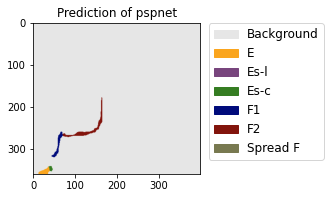

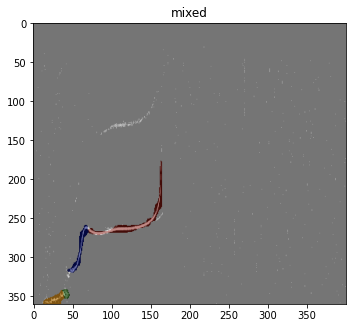

164 163
271 271


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: The handle <matplotlib.patches.Rectangle object at 0x7f0b312d5250> has a label of '_nolegend_' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: The handle <matplotlib.patches.Rectangle object at 0x7f0b312d5810> has a label of '_nolegend_' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: The handle <matplotlib.patches.Rectangle object at 0x7f0b312d5d50> has a label of '_nolegend_' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: The handle <matplotlib.patches.Rectangle object at 0x7f0b45b43650> has a label of '_nolegend_' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: The handle <matplotlib.pat

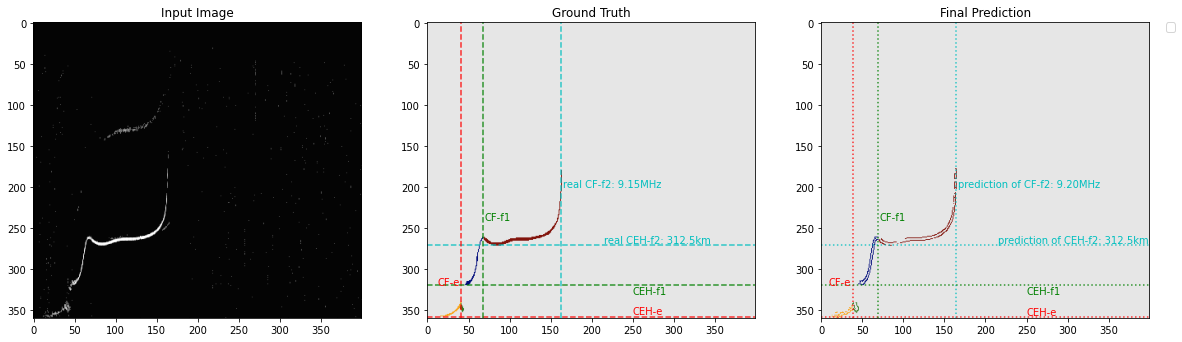

No. 253


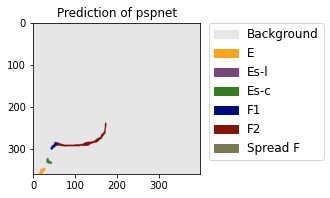

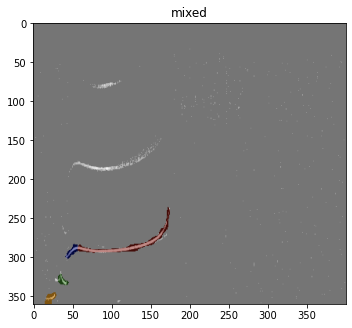

174 175
293 294


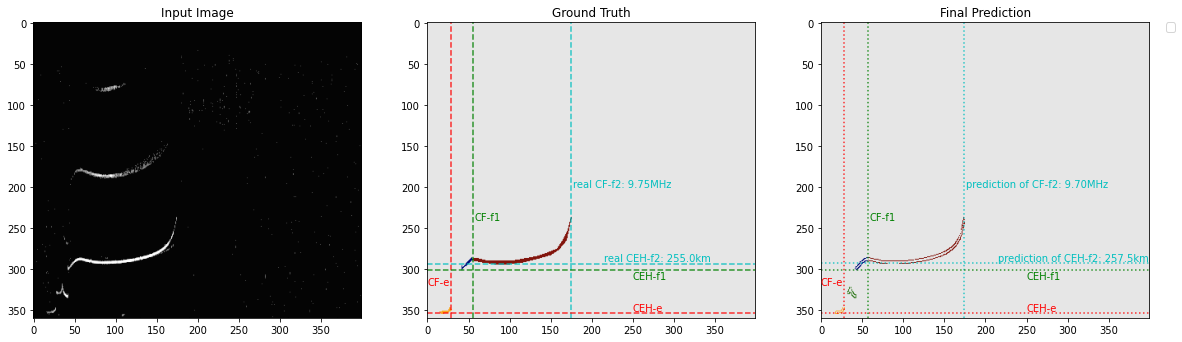

No. 381


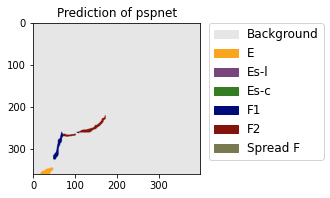

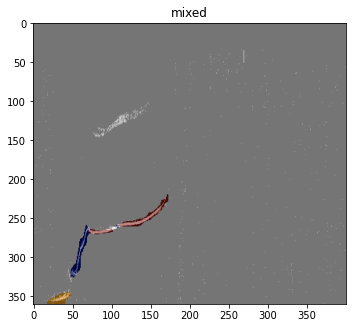

170 171
270 271


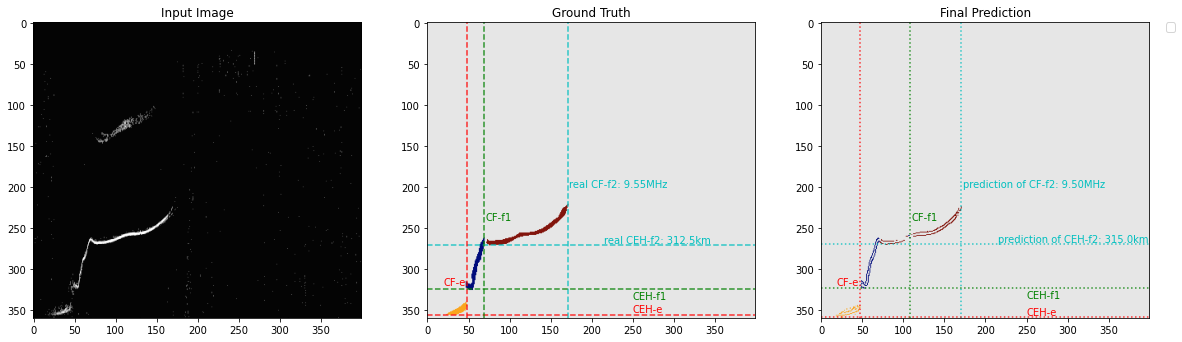

No. 445


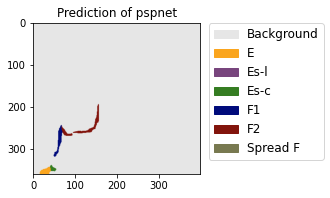

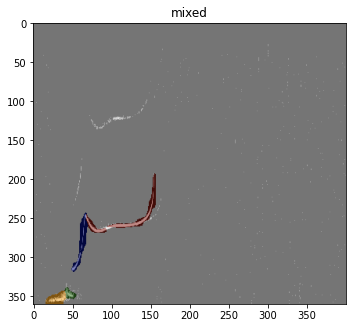

155 156
268 269


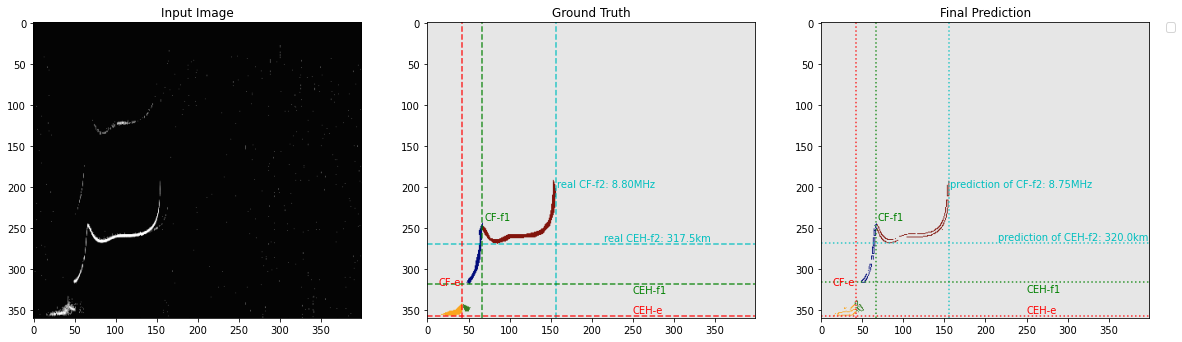

No. 778


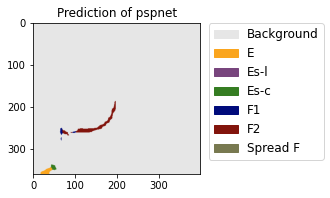

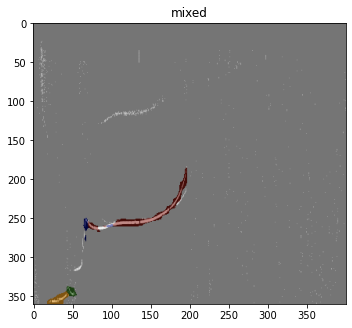

196 196
265 265


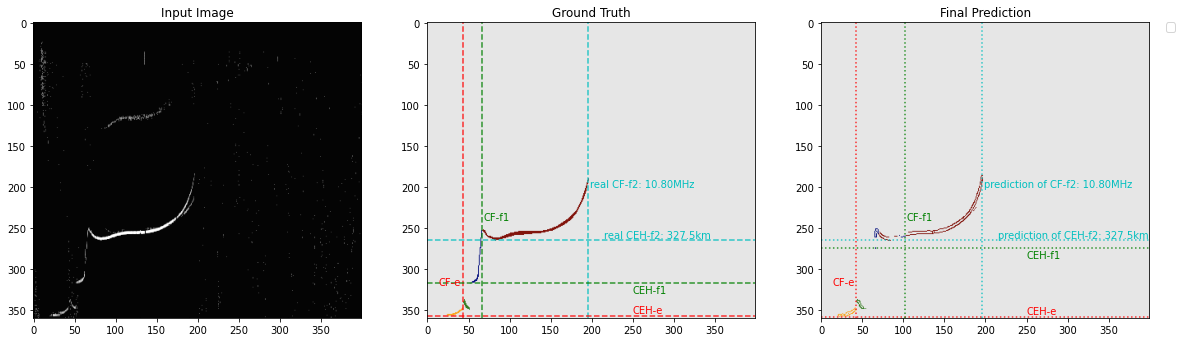

No. 782


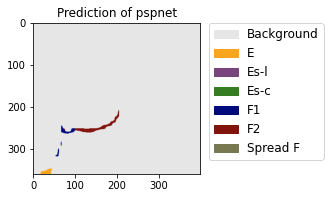

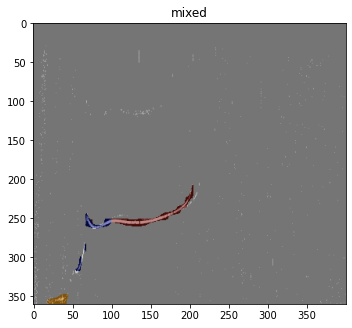

204 203
257 264


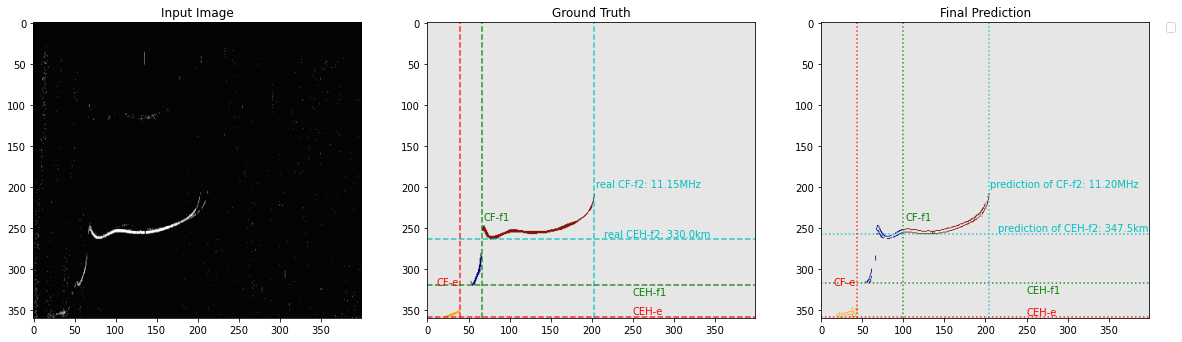

No. 785


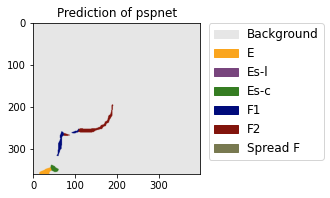

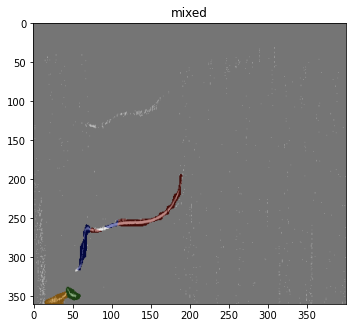

190 192
267 268


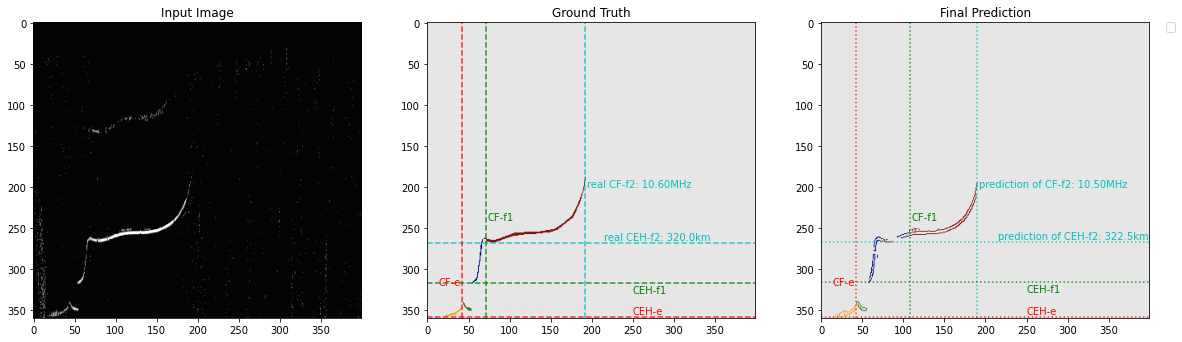

In [ ]:
# dev = np.array(list_d)
print(np.shape(dev))
dh = dev[:,2]
df = dev[:,3]
print('dh: ', np.unique(dh))
print('df: ', np.unique(df))

mdh = np.mean((dh)) 
mdf = np.mean((df)) 


devs = dev[:, 2:3]
print('mdh = ', mdh)
print('mdf = ',mdf)

dev_id = np.argwhere(abs(df) > 30)
print(dev_id)
print(len(dev_id))

for i in range(len(dev_id)):
  cnt = dev[dev_id[i,0], 0]
  check(cnt)



In [ ]:
def check(cnt):
  print('No.', cnt)
  name = name_list[cnt]
  [gimg, cimg, label, cmask, seg] = single_load(name)
  result = inference_segmentor(model, cimg)
  # show result
  plt.figure(figsize=(3,3))
  plt.title('Prediction of pspnet')
  seg_res = Image.fromarray(np.uint8(result[0])).convert('P')
  seg_res.putpalette(np.array(palette, dtype=np.uint8))
  im = plt.imshow(np.array(seg_res.convert('RGB')))
  patches = [mpatches.Patch(color=np.array(palette[i])/255.,label=classes[i]) for i in range(7)]
  plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='large')

  show_result_pyplot(model, cimg, result, fig_size=(5,5), title='mixed')
  ############ postprocess###########
  segmap = seg
  segmap = post_seg(seg, cimg)        
  # 计算临界参数
  [mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred] = interpret(segmap)
  [mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth] = interpret(label)

  print(mf_pred,mf_truth)
  print(mh_pred,mh_truth)

  show_cha_pyplot(cimg, cmask, segmap, palette,
                            mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred,
                            mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth)

### 画图

#### 判读结果组图

No. 0
91 90
283 282


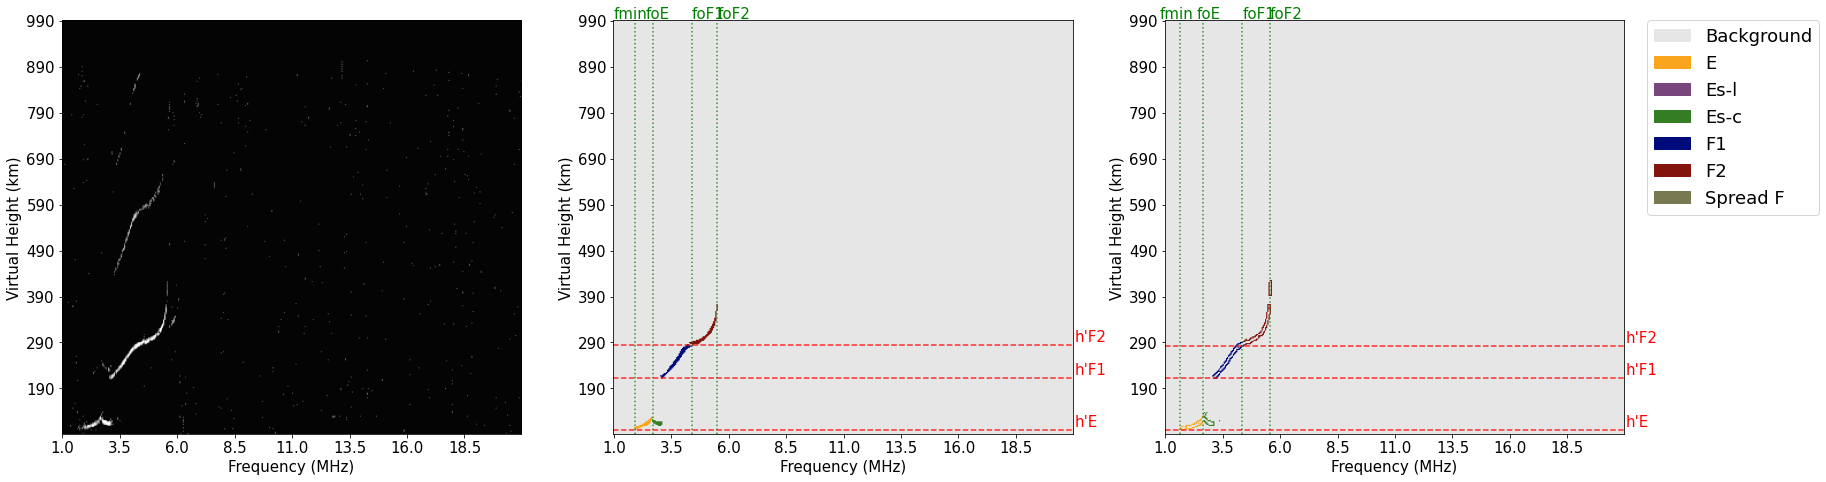

No. 700
159 159
284 285


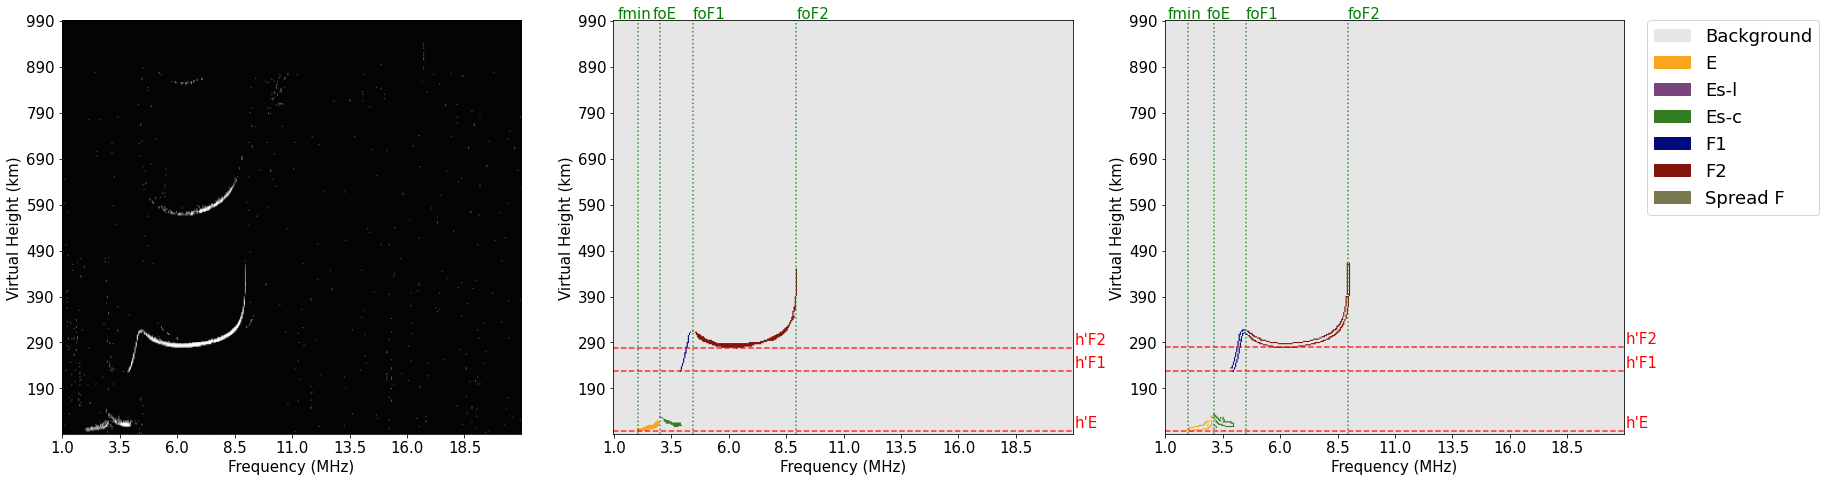

No. 780
158 158
281 282


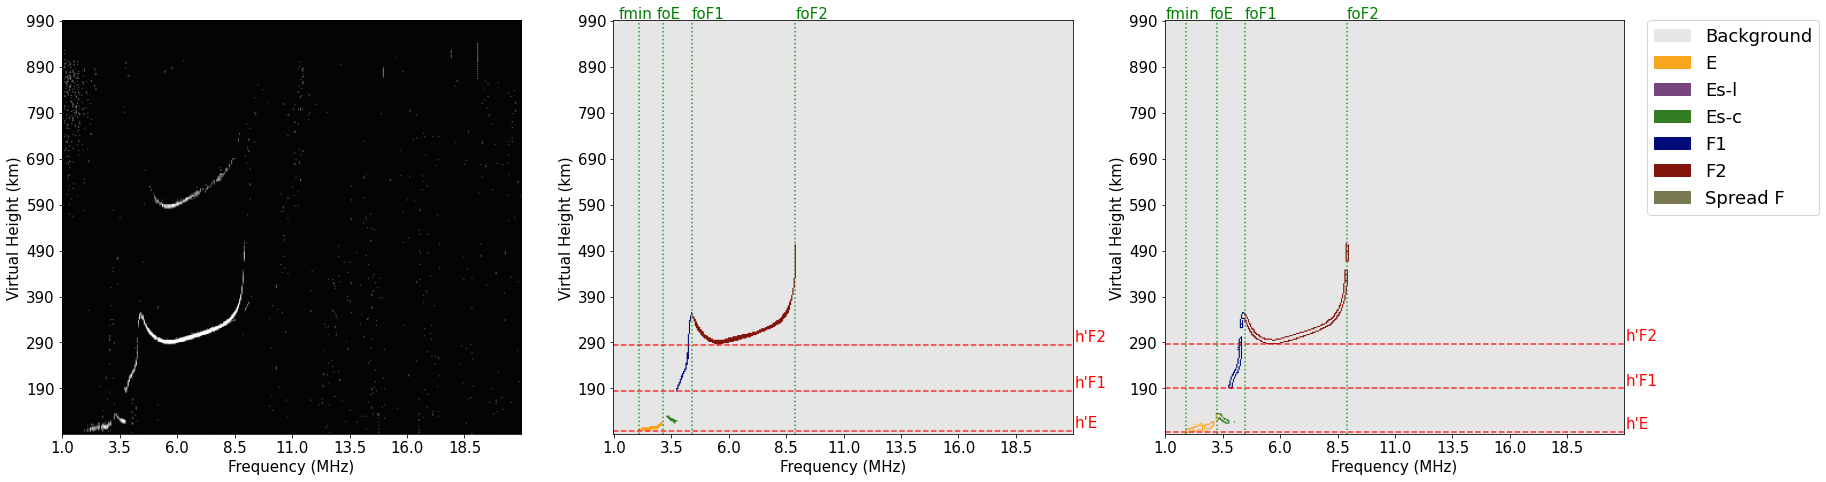

No. 160
115 113
284 284


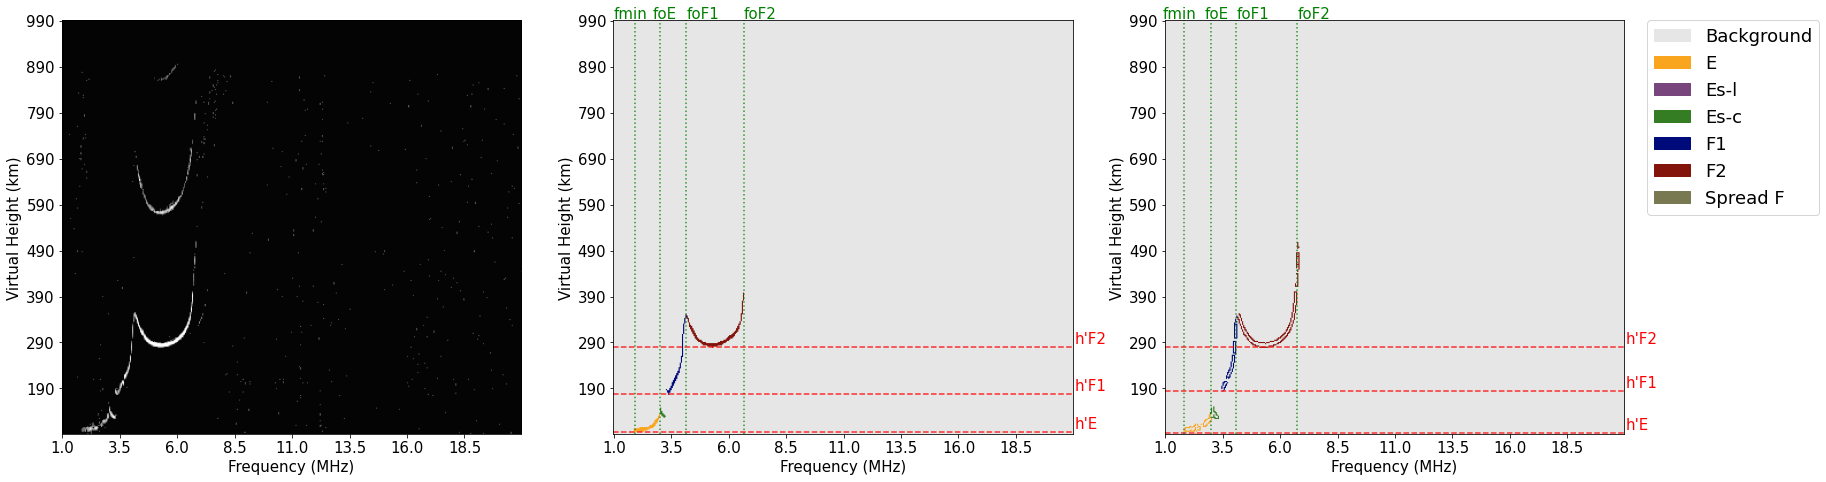

No. 580
167 168
310 310


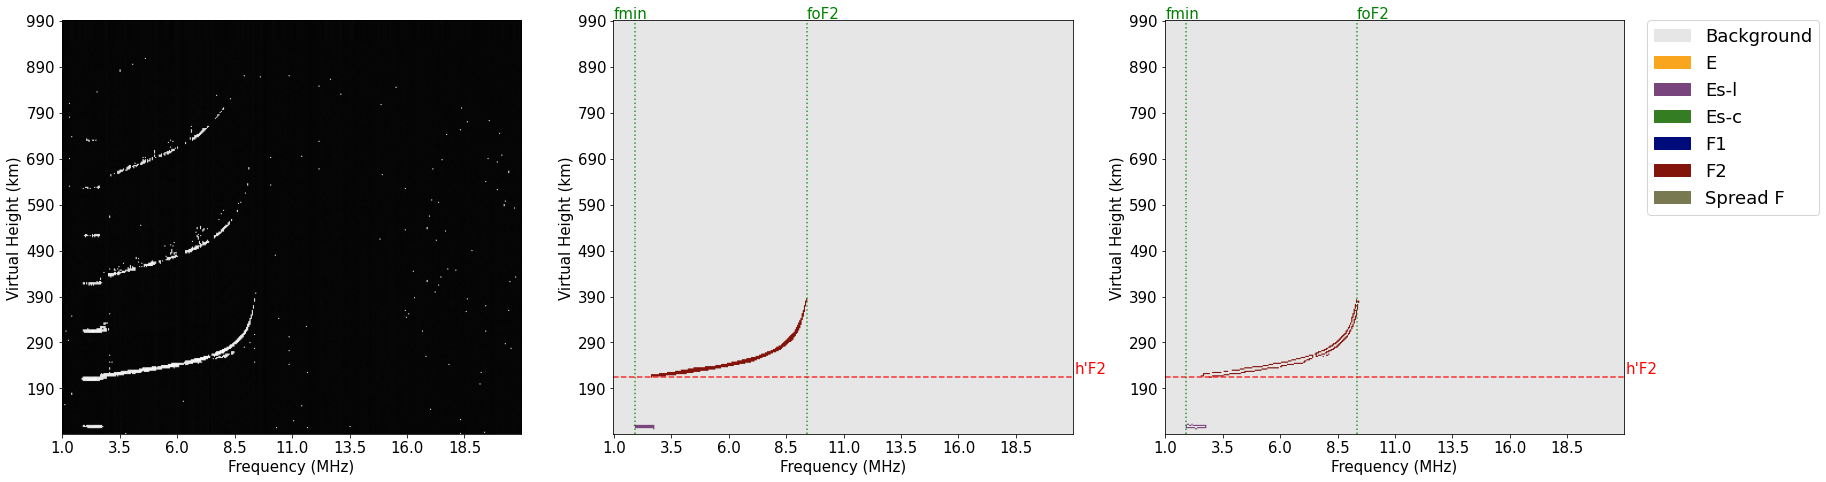

No. 281
94 94
277 273


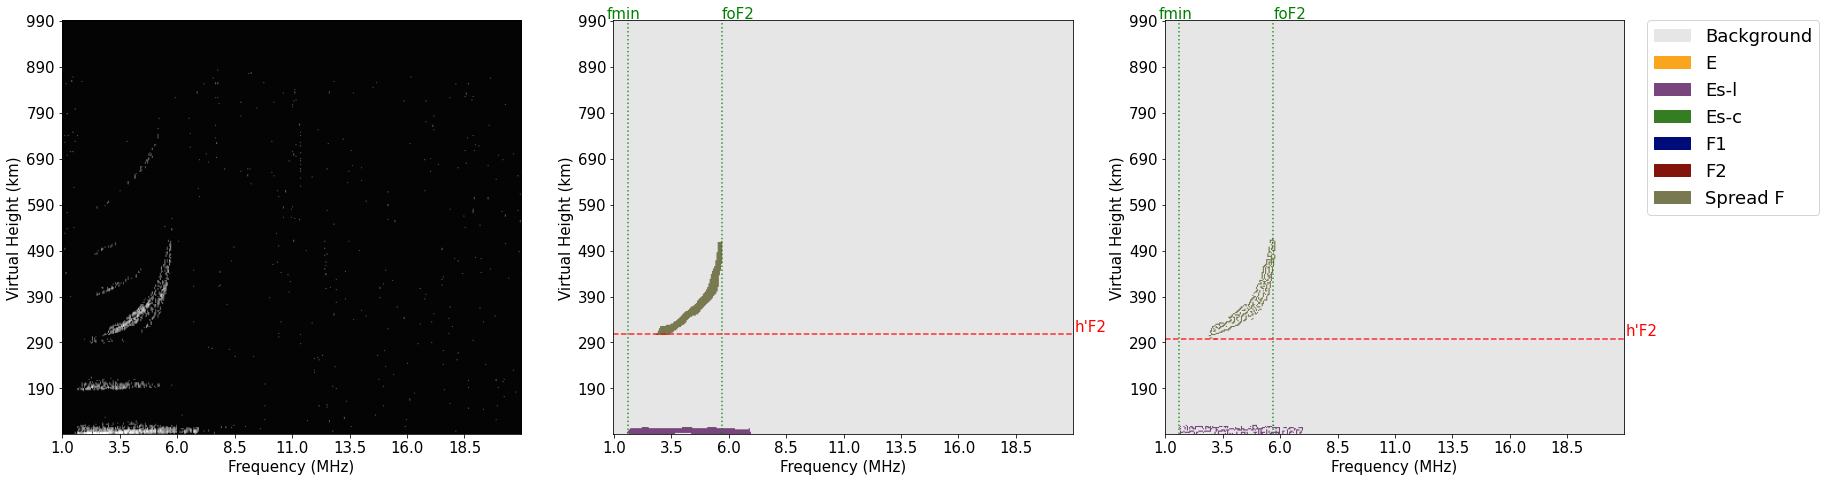

No. 277
91 92
285 285


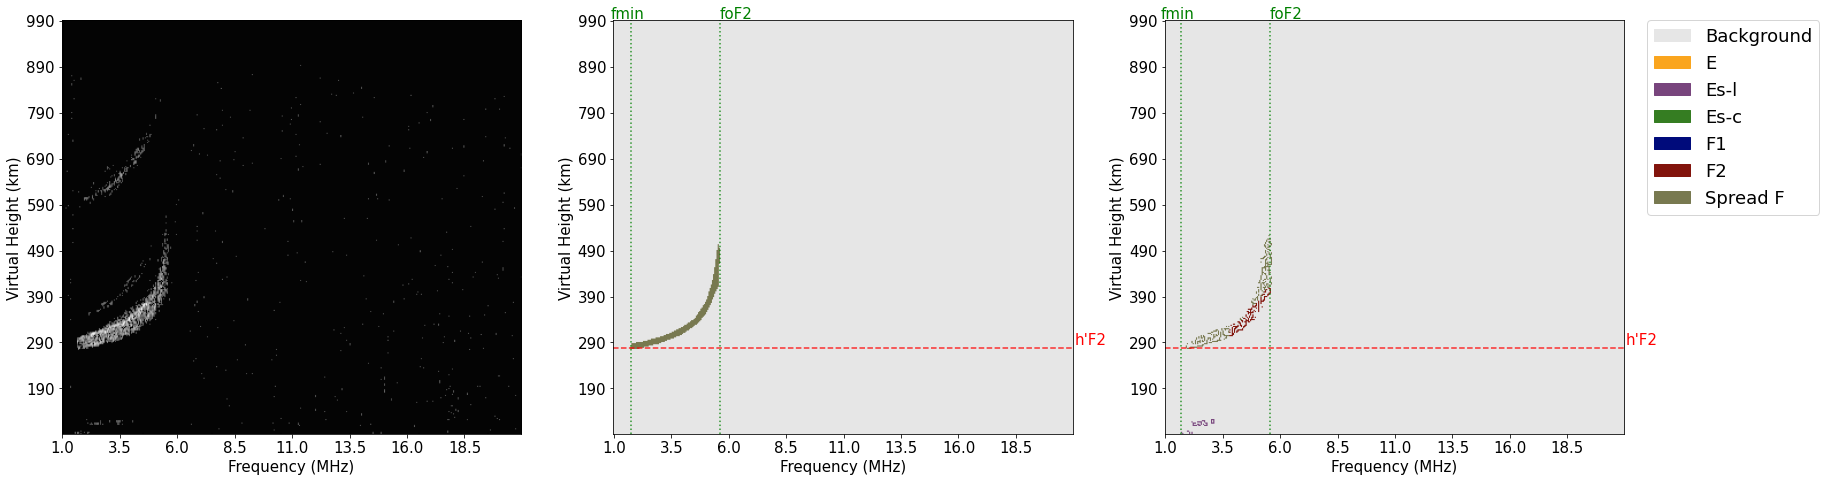

No. 552
155 155
289 289


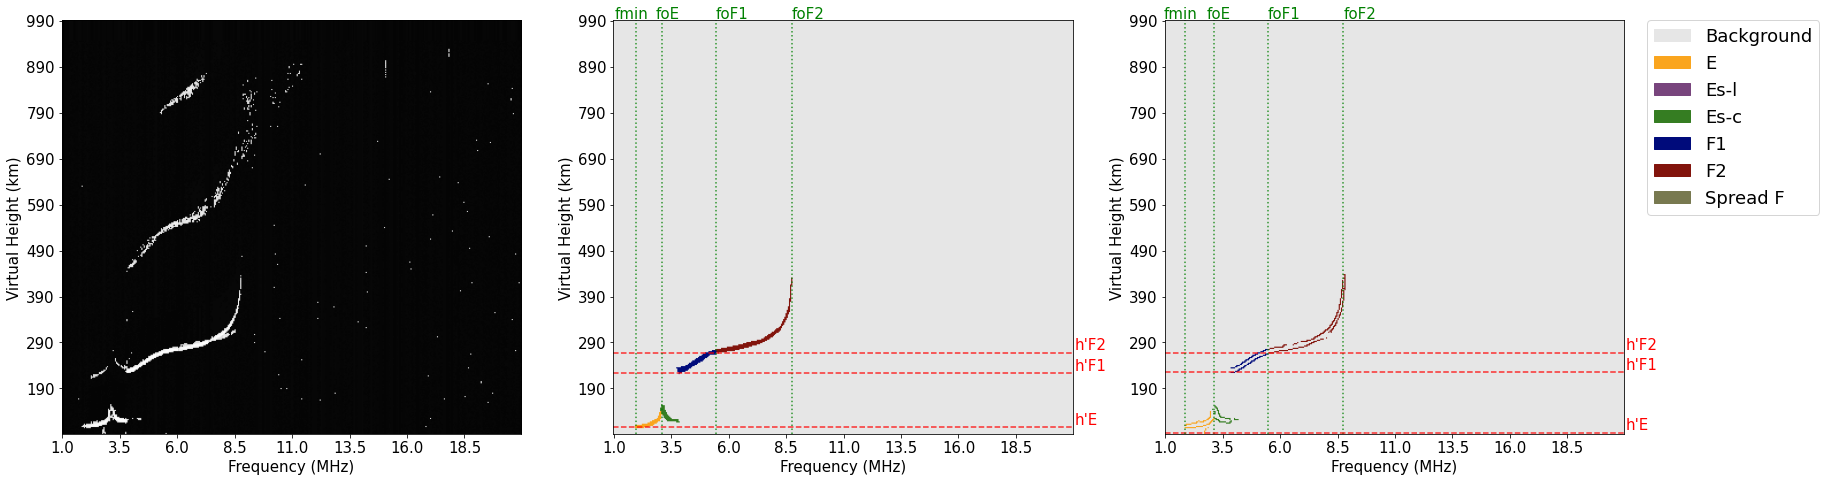

17.183743926000716 s


In [ ]:
# 202开始有Fspread
cnt = 295                          # 开始序号
sample_interval = 2   # 画图抽样间隔
tic1  = time.perf_counter()
pic = list([0, 700, 780, 160, 580, 281, 277, 552])
for cnt in pic:
  print('No.', cnt)
  name = name_list[cnt]
  [gimg, cimg, label, cmask, seg] = single_load(name)
  segmap = seg
  ############ postprocess###########
  segmap = post_seg(seg, cimg)        
  
  # 计算临界参数
  [mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin_pred] = interpret(segmap)
  [mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth] = interpret(label)
  mf_pred = mf_pred - 1
  print(mf_pred,mf_truth)
  print(mh_pred,mh_truth)

  show_cha_pyplot(cimg, cmask, segmap, palette,
                            mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin_pred,
                            mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth)

tic2  = time.perf_counter()
print(tic2 - tic1,'s')

In [ ]:
x = []
for i in range(10):
  x.append(40*i)
print(x)
import matplotlib 


[0, 40, 80, 120, 160, 200, 240, 280, 320, 360]


#### 判读结果 大图

No. 780
158 158
281 282


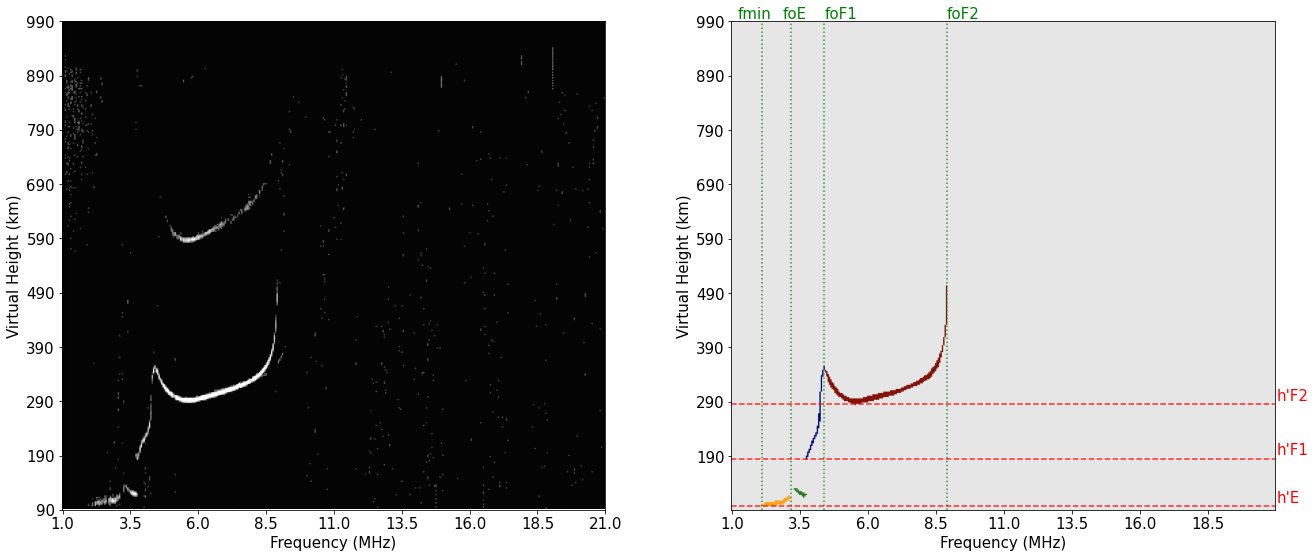

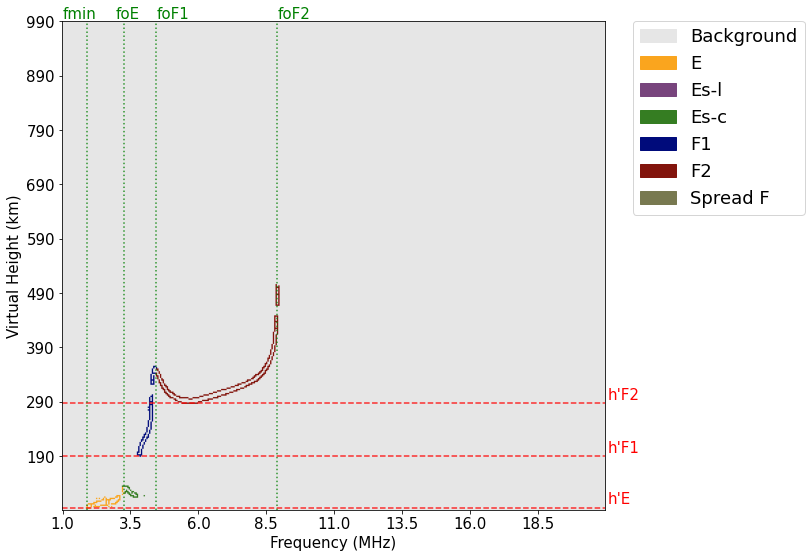

3.629980211999282 s


In [ ]:
def show_cha_pyplot2(cimg, cmask, segmap, palette,
                                  mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin_pred,
                                  mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth):

  font = {'size': 15}

  matplotlib.rc('font', **font)


  plt.figure(figsize=(22, 9))
  plt.subplot(121)
  plt.imshow(cimg)
  plt.xlabel('Frequency (MHz)')
  plt.ylabel('Virtual Height (km)')
  plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
  plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
  # plt.show()
  plt.subplot(122)
  plt.xlabel('Frequency (MHz)')
  plt.ylabel('Virtual Height (km)')
  plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
  plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
  # plt.title('Ground Truth')
  plt.imshow(cmask)
  # f2
  plt.axvline(mf_truth,color='g',linestyle=":",alpha=0.8) 
  plt.text(mf_truth, -2,'foF2', color = 'g')
  plt.axhline(mh_truth,color='r',linestyle="--",alpha=0.8) 
  plt.text(401, mh_truth-3,'h\'F2', color = 'r')
  # E
  if mfe_truth > 0:
    plt.axvline(mfe_truth,color='g',linestyle=":",alpha=0.8) 
    plt.text(mfe_truth-6, -2,'foE', color = 'g')
    plt.axhline(mhe_truth,color='r',linestyle="--",alpha=0.8)
    plt.text(401, mhe_truth-3,'h\'E', color = 'r')
  # f1
  if mff1_truth > 0:
    plt.axvline(mff1_truth,color='g',linestyle=":",alpha=0.8) 
    plt.text(mff1_truth, -2,'foF1', color = 'g')
    plt.axhline(mhf1_truth,color='r',linestyle="--",alpha=0.8)  
    plt.text(401, mhf1_truth-3,'h\'F1', color = 'r')
  if fmin_pred > 0:
    plt.axvline(fmin_truth,color='g',linestyle=":",alpha=0.8) 
    plt.text(fmin_truth-18, -2,'fmin', color = 'g')

  plt.figure(figsize=(10, 9))
  plt.xlabel('Frequency (MHz)')
  plt.ylabel('Virtual Height (km)')
  plt.yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360],[990, 890, 790, 690, 590, 490, 390, 290, 190, 90])
  plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400],[1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0])
  # plt.title('Final Prediction')
  seg_res = Image.fromarray(np.uint8(segmap)).convert('P')
  seg_res.putpalette(np.array(palette, dtype=np.uint8))
  im = plt.imshow(np.array(seg_res.convert('RGB')))
  plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='large')
  # f2
  plt.axvline(mf_pred,color='g',linestyle=":",alpha=0.8) 
  plt.text(mf_pred, -2,'foF2', color = 'g')
  plt.axhline(mh_pred,color='r',linestyle="--",alpha=0.8) 
  plt.text(401, mh_pred-3,'h\'F2', color = 'r')
  # E
  if mfe_pred > 0:
    plt.axvline(mfe_pred,color='g',linestyle=":",alpha=0.8) 
    plt.text(mfe_pred-6, -2,'foE', color = 'g')
    plt.axhline(mhe_pred,color='r',linestyle="--",alpha=0.8) 
    plt.text(401, mhe_pred-3,'h\'E', color = 'r')
  # f1
  if mff1_pred > 0:
    plt.axvline(mff1_pred,color='g',linestyle=":",alpha=0.8) 
    plt.text(mff1_pred, -2,'foF1', color = 'g')
    plt.axhline(mhf1_pred,color='r',linestyle="--",alpha=0.8) 
    plt.text(401, mhf1_pred-3,'h\'F1', color = 'r')
  if fmin_pred > 0:
    plt.axvline(fmin_pred,color='g',linestyle=":",alpha=0.8) 
    plt.text(fmin_pred-18, -2,'fmin', color = 'g')

  plt.show()

# 202开始有Fspread
cnt = 295                          # 开始序号
sample_interval = 2   # 画图抽样间隔
tic1  = time.perf_counter()
pic = list([780])
for cnt in pic:
  print('No.', cnt)
  name = name_list[cnt]
  [gimg, cimg, label, cmask, seg] = single_load(name)
  segmap = seg
  ############ postprocess###########
  segmap = post_seg(seg, cimg)        
  
  # 计算临界参数
  [mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin_pred] = interpret(segmap)
  [mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth] = interpret(label)
  mf_pred = mf_pred - 1
  print(mf_pred,mf_truth)
  print(mh_pred,mh_truth)

  show_cha_pyplot2(cimg, cmask, segmap, palette,
                            mh_pred, mf_pred, mhe_pred, mfe_pred, mhf1_pred, mff1_pred, fmin_pred,
                            mh_truth, mf_truth, mhe_truth, mfe_truth, mhf1_truth, mff1_truth, fmin_truth)

tic2  = time.perf_counter()
print(tic2 - tic1,'s')